# Section 1: Data Import and Preparation
This section imports the necessary libraries and reads data from the specified files. The data has been sourced as a snapshot from Refinitiv and is up-to-date as of July 13, 2024. The data is processed to calculate the mid rates.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import QuantLib as ql
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import FuncFormatter
from datetime import datetime
from scipy.stats import ttest_1samp

# Input file paths
ois_file_path = 'Dati/EURESTOIS=.xlsm'
forwards_ois_ecb_file_path = 'Dati/EUESTECBF=ICAP.xlsm'
deposit_file_path = 'Dati/EURDEPO=.xlsm'
fra3M_file_path = 'Dati/EUR3MFRA=.xlsm'
fra6M_file_path = 'Dati/6M/EUR6MFRA=.xlsm'
swap3M_file_path = 'Dati/EURAB3EIRS=.xlsm'
swap6M_file_path = 'Dati/6M/EURAB6EIRS=.xlsm'
futures3M_file_path = 'Dati/FUTURE3M.xlsm'

# ECB maintenance periods
ecb_maintenance_periods = {
    "JAN24": {"start": ql.Date(31, ql.January, 2024), "end": ql.Date(12, ql.March, 2024)},
    "MAR24": {"start": ql.Date(13, ql.March, 2024), "end": ql.Date(16, ql.April, 2024)},
    "APR24": {"start": ql.Date(17, ql.April, 2024), "end": ql.Date(11, ql.June, 2024)},
    "JUN24": {"start": ql.Date(12, ql.June, 2024), "end": ql.Date(23, ql.July, 2024)},
    "JUL24": {"start": ql.Date(24, ql.July, 2024), "end": ql.Date(17, ql.September, 2024)},
    "SEP24": {"start": ql.Date(18, ql.September, 2024), "end": ql.Date(22, ql.October, 2024)},
    "OCT24": {"start": ql.Date(23, ql.October, 2024), "end": ql.Date(17, ql.December, 2024)},
    "DEC24": {"start": ql.Date(18, ql.December, 2024), "end": "tbd"}
}

# Function to read data and calculate average rates
def load_and_process_data(file_path, sheet_name):
    data = pd.read_excel(file_path, sheet_name=sheet_name, engine='openpyxl')
    data['Mid'] = (data['Bid'] + data['Ask']) / 2
    return data

# Load and process data
ois_data = load_and_process_data(ois_file_path, 'Sheet1')
forwards_ois_ecb_data = load_and_process_data(forwards_ois_ecb_file_path, 'Sheet1')
deposit_data = load_and_process_data(deposit_file_path, 'Sheet1')
fra_data3M = load_and_process_data(fra3M_file_path, 'Sheet1')
fra_data3M_0x3_rate = pd.DataFrame({'Maturity':['0X3','1X4'], 'Bid':[3.654,3.579],'Ask':[3.674,3.599]}) # 12/07/2024 0x3 rate, different contributor than the other fra rates
fra_data3M_0x3_rate['Mid'] = (fra_data3M_0x3_rate['Bid'] + fra_data3M_0x3_rate['Ask']) / 2
fra_data6M = load_and_process_data(fra6M_file_path, 'Sheet1')
fra_data6M_0x6_rate = pd.DataFrame({'Maturity':['0X6'], 'Bid':[3.652],'Ask':[3.672]}) # 12/07/2024 0x6 rate, different contributor than the other fra rates
fra_data6M_0x6_rate['Mid'] = (fra_data6M_0x6_rate['Bid'] + fra_data6M_0x6_rate['Ask']) / 2
swap_data3M = load_and_process_data(swap3M_file_path, 'Sheet1')
swap_data6M = load_and_process_data(swap6M_file_path, 'Sheet1')
futures_data3M = load_and_process_data(futures3M_file_path, 'Sheet1')

# Merge fra 3M and 6M data
fra_data3M = pd.concat([fra_data3M_0x3_rate, fra_data3M], ignore_index=True)
fra_data6M = pd.concat([fra_data6M_0x6_rate, fra_data6M], ignore_index=True)

# Set Golden ratio figure size
width = 12  
height = width / 1.618 

# Section 2: Convert Maturities and Set Evaluation Date
This section defines functions to convert maturity strings into QuantLib periods and processes the dataset to include these periods. It also sets up necessary adjustments for ECB maintenance periods and futures maturities, and defines specific maturities based on the Ametrano and Bianchetti study. The evaluation date for all calculations is set at the end.

In [2]:
# Map to convert calendar units to QuantLib periods
period_map = {
    "D": ql.Days,
    "W": ql.Weeks,
    "M": ql.Months,
    "Y": ql.Years
}

# Map for fixing days
fixing_days_map = {
    "ON": 0,
    "TN": 1,
    "SN": 2,
    "SW": 2,
    "2W": 2,
    "3W": 2
}

# Function to convert maturities to QuantLib periods, handling special cases
def convert_to_period(maturity):
    special_maturity_format = {
        "ON": ql.Period(1, ql.Days),
        "TN": ql.Period(2, ql.Days),
        "SN": ql.Period(3, ql.Days),
        "SW": ql.Period(1, ql.Weeks)
    }
    
    if maturity in special_maturity_format:
        return special_maturity_format[maturity]
    
    try:
        if 'X' in maturity:
            start, end = maturity.split('X')
            return ql.Period(int(start), ql.Months), ql.Period(int(end), ql.Months)
        num = int(maturity[:-1])
    except ValueError:
        raise ValueError(f"Invalid maturity format: {maturity}")
    
    unit = maturity[-1]
    return ql.Period(num, period_map[unit])

# Function to convert QuantLib dates to datetime for matplotlib
def _to_datetime(_date):
    return datetime(_date.year(), _date.month(), _date.dayOfMonth())

# Convert maturities to QuantLib periods
ois_data['Period'] = ois_data['Maturity'].apply(convert_to_period)
deposit_data['Period'] = deposit_data['Maturity'].apply(convert_to_period)
fra_data3M['Start_Period'], fra_data3M['End_Period'] = zip(*fra_data3M['Maturity'].apply(convert_to_period))
fra_data6M['Start_Period'], fra_data6M['End_Period'] = zip(*fra_data6M['Maturity'].apply(convert_to_period))
swap_data3M['Period'] = swap_data3M['Maturity'].apply(convert_to_period)
swap_data6M['Period'] = swap_data6M['Maturity'].apply(convert_to_period)

# Process forward OIS ECB data within maintenance periods
# Remove unused maintenance periods
del ecb_maintenance_periods["JAN24"]
del ecb_maintenance_periods["MAR24"]
del ecb_maintenance_periods["APR24"]
del ecb_maintenance_periods["JUN24"]
del ecb_maintenance_periods["DEC24"]

# Remove unused forward OIS ECB data
forwards_ois_ecb_data = forwards_ois_ecb_data[(forwards_ois_ecb_data.index > 0) & (forwards_ois_ecb_data.index < 4)]

# Set start and end dates for maintenance periods and forward OIS ECB maturities
period_keys = list(ecb_maintenance_periods.keys())
forwards_ois_ecb_data['Start_Period'] = [ecb_maintenance_periods[key]['start'] for key in period_keys[:len(forwards_ois_ecb_data)]]
forwards_ois_ecb_data['End_Period'] = [ecb_maintenance_periods[key]['end'] + 1 for key in period_keys[:len(forwards_ois_ecb_data)]]
forwards_ois_ecb_data.drop(columns=['Maturity'], inplace=True)

# Set IMM dates for Euribor futures maturities
def imm_date_corrected(data):
    month_str = data[:3]  # First three characters represent the month (e.g., 'JUL')
    year_str = data[3:]   # Remaining characters represent the year (e.g., '4')

    month = datetime.strptime(month_str, '%b').month
    year = 2020 + int(year_str)  # Corrected to handle years in 2020s
    
    # Calculate the next IMM date
    date = datetime(year, month, 1)
    return ql.IMM.nextDate(ql.Date(date.day, date.month, date.year))

futures_data3M['Start_Date'] = futures_data3M['Maturity'].apply(imm_date_corrected)
futures_data3M = futures_data3M[(futures_data3M.index > 4) & (futures_data3M.index < 11)]

# Define maturities based on Ametrano and Bianchetti study
ESTR_curve_deposit_maturities_chosen = ['ON', 'TN', 'SN'] 
fra3M_maturities_chosen = ['2X5','3X6', '4X7', '5X8', '6X9', '7X10', '8X11', '9X12','12X15','15X18', '16X19', '18X21','21X24']
fra_maturities_chosen = ['1X7', '2X8', '3X9', '4X10', '5X11', '6X12', '7X13', '8X14', '9X15', '10X16', '11X17', '12X18', '18X24']
swap_maturities_chosen = ['3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '12Y', '15Y', '20Y', '25Y', '30Y', '40Y', '50Y']
futures_maturities_chosen = ['DEC4', 'MAR5', 'JUN5', 'SEP5', 'DEC5', 'MAR6']

# DEBUG: Print data
DEBUG_DATI = False
if DEBUG_DATI:
    print(f"Deposit Data: {deposit_data}")
    print(f"OIS Data: {ois_data}")
    print(f"Forwards OIS ECB Data: {forwards_ois_ecb_data}")
    print(f"FRA Data: {fra_data3M}")
    print(f"Swap Data: {swap_data3M}")
    print(f"Futures Data: {futures_data3M}")

# Set the evaluation date for the curves
settle_date = ql.Date(12, 7, 2024)
ql.Settings.instance().evaluationDate = settle_date




# Section 3: Building the €STR Discount Curve
This section defines a function to build the €STR discount curve. It initializes the curve with selected deposits, OIS pre-ECB, forward OIS ECB, and OIS post-ECB data. The function also includes an option to visualize the resulting yield curve.

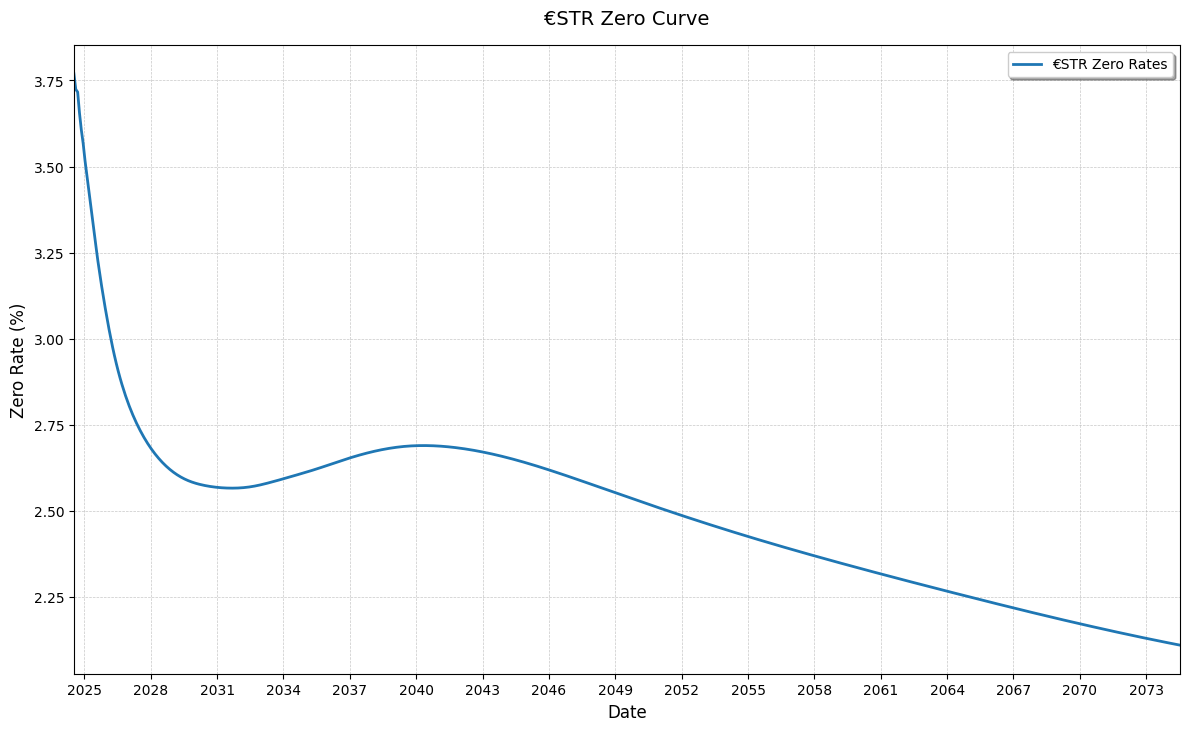

€STR Curve Instruments Summary:


Instrument  Tenor            Start Date         Maturity Date    Bid   
0           Deposit     ON       July 12th, 2024       July 15th, 2024  3.660  \
1           Deposit     TN       July 15th, 2024       July 16th, 2024  3.550   
2           Deposit     SN       July 16th, 2024       July 17th, 2024  3.550   
3               OIS     SW       July 16th, 2024       July 23rd, 2024  3.662   
4   Forward OIS ECB  Dated       July 24th, 2024  September 18th, 2024  3.637   
5   Forward OIS ECB  Dated  September 18th, 2024    October 23rd, 2024  3.426   
6   Forward OIS ECB  Dated    October 23rd, 2024   December 18th, 2024  3.355   
7               OIS     6M       July 16th, 2024    January 16th, 2025  3.467   
8               OIS     7M       July 16th, 2024   February 17th, 2025  3.429   
9               OIS     8M       July 16th, 2024      March 17th, 2025  3.396   
10              OIS     9M       July 16th, 2024      April 16th, 2025  3.355   
11              OIS    10M       July 16th, 2024        May 16th, 2025  3.317   
12              OIS    11M       July 16th, 2024       June 16th, 2025  3.282   
13              OIS     1Y       July 16th, 2024       July 16th, 2025  3.244   
14              OIS    15M       July 16th, 2024    October 16th, 2025  3.123   
15              OIS    18M       July 16th, 2024    January 16th, 2026  3.027   
16              OIS    21M       July 16th, 2024      April 16th, 2026  2.945   
17              OIS     2Y       July 16th, 2024       July 16th, 2026  2.887   
18              OIS     3Y       July 16th, 2024       July 16th, 2027  2.716   
19              OIS     4Y       July 16th, 2024       July 17th, 2028  2.625   
20              OIS     5Y       July 16th, 2024       July 16th, 2029  2.578   
21              OIS     6Y       July 16th, 2024       July 16th, 2030  2.558   
22              OIS     7Y       July 16th, 2024       July 16th, 2031  2.551   
23              OIS     8Y       July 16th, 2024       July 16th, 2032  2.554   
24              OIS     9Y       July 16th, 2024       July 18th, 2033  2.567   
25              OIS    10Y       July 16th, 2024       July 17th, 2034  2.583   
26              OIS    11Y       July 16th, 2024       July 16th, 2035  2.600   
27              OIS    12Y       July 16th, 2024       July 16th, 2036  2.619   
28              OIS    15Y       July 16th, 2024       July 18th, 2039  2.657   
29              OIS    20Y       July 16th, 2024       July 18th, 2044  2.627   
30              OIS    25Y       July 16th, 2024       July 16th, 2049  2.545   
31              OIS    30Y       July 16th, 2024       July 16th, 2054  2.464   
32              OIS    40Y       July 16th, 2024       July 16th, 2064  2.326   
33              OIS    50Y       July 16th, 2024       July 16th, 2074  2.217   
34              OIS    60Y       July 16th, 2024       July 17th, 2084  2.141   

      Ask    Mid  
0   3.780  3.720  
1   3.900  3.725  
2   3.900  3.725  
3   3.666  3.664  
4   3.687  3.662  
5   3.476  3.451  
6   3.405  3.380  
7   3.508  3.488  
8   3.470  3.450  
9   3.437  3.416  
10  3.396  3.375  
11  3.358  3.338  
12  3.323  3.302  
13  3.285  3.264  
14  3.164  3.144  
15  3.068  3.048  
16  2.995  2.970  
17  2.928  2.907  
18  2.757  2.737  
19  2.666  2.646  
20  2.619  2.598  
21  2.599  2.578  
22  2.592  2.572  
23  2.595  2.574  
24  2.608  2.588  
25  2.624  2.604  
26  2.641  2.620  
27  2.660  2.640  
28  2.698  2.678  
29  2.668  2.648  
30  2.586  2.566  
31  2.505  2.484  
32  2.376  2.351  
33  2.267  2.242  
34  2.191  2.166

In [3]:
def estr_curve_builder(
    ois_data=ois_data,
    deposit_data=deposit_data,
    forwards_ois_ecb_data=forwards_ois_ecb_data,
    graph=True):
    
    # Initialize an empty list to contain €STR curve helpers
    estr_helpers = []

    # Initialize the €STR curve
    estr = ql.Estr()

    # 1) Deposits
    # Add helpers for the first part of the curve from selected deposits
    selected_depo_data = deposit_data[deposit_data['Maturity'].isin(ESTR_curve_deposit_maturities_chosen)]

    estr_helpers += [
        ql.DepositRateHelper(
            ql.QuoteHandle(ql.SimpleQuote(row['Mid'] / 100)),
            ql.Period(1, ql.Days),
            fixing_days_map[row['Maturity']],
            ql.TARGET(),
            ql.Following,
            False,
            ql.Actual360()
        )
        for _, row in selected_depo_data.iterrows()
    ]

    # 2) OIS pre-ECB
    ois_pre_ecb = ois_data[ois_data.index < 1] # Watch for overlapping with forward OIS ECB
    # Add helpers for the second part of the curve from selected OIS pre-ECB
    estr_helpers += [
        ql.OISRateHelper(
            2, row['Period'], ql.QuoteHandle(ql.SimpleQuote(row['Mid'] / 100)), estr
        )
        for index, row in ois_pre_ecb.iterrows()
    ]

    # 3) Forward OIS ECB dates
    # Add helpers for the third part of the curve from selected Forward OIS ECB
    estr_helpers += [
        ql.DatedOISRateHelper(
            row['Start_Period'], row['End_Period'], ql.QuoteHandle(ql.SimpleQuote(row['Mid'] / 100)), estr
        )
        for index, row in forwards_ois_ecb_data.iterrows()
    ]

    # 4) OIS post-ECB
    ois_post_ecb = ois_data[ois_data.index > 7] # Watch for overlapping with forward OIS ECB
    estr_helpers += [
        ql.OISRateHelper(
            2, row['Period'], ql.QuoteHandle(ql.SimpleQuote(row['Mid'] / 100)), estr
        )
        for index, row in ois_post_ecb.iterrows()
    ]

    # DEBUG: Print details of all helpers
    DEBUG_ESTR = False
    if DEBUG_ESTR:
        print("€STR Helpers:")
        for helper in estr_helpers:
            helper_type = type(helper).__name__
            start_date = helper.earliestDate()
            maturity_date = helper.maturityDate()
            quote = helper.quote().value()
            pillar_date = helper.pillarDate()
            print(f"Type: {helper_type}, Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}, Pillar Date: {pillar_date}")

    # Build the €STR discount curve
    estr_curve = ql.PiecewiseLogCubicDiscount(0, ql.TARGET(), estr_helpers, ql.Actual365Fixed())
    estr_curve.enableExtrapolation() # Enable extrapolation for dates beyond the available data

    # Calculate discount factors for specified dates
    dates = [settle_date + ql.Period(i, ql.Months) for i in range(0, 50 * 12 + 1)]

    # Convert dates to datetime format
    dates_dt = [_to_datetime(date) for date in dates]
    estr_zero_rates = [
        estr_curve.zeroRate(date, ql.Actual365Fixed(), ql.Continuous).rate()
        for date in dates
    ]

    # Create the €STR yield curve graph and display the €STR curve instruments summary
    if graph:
        plt.figure(figsize=(width, height))
        estr_zero_rates_percent = [rate * 100  for rate in estr_zero_rates]
        plt.plot(dates_dt, estr_zero_rates_percent, label='€STR Zero Rates', linewidth=2)
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
        plt.xlim(dates_dt[0], dates_dt[-1])
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Zero Rate (%)', fontsize=12)
        plt.title('€STR Zero Curve', fontsize=14, pad=15)
        plt.legend(loc='upper right', fontsize=10, frameon=True, shadow=True, fancybox=True)
        plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
        plt.tight_layout()
        plt.show()

        # Create a DataFrame to display the €STR curve instruments summary
        combined_data_estr = pd.concat([
            selected_depo_data.assign(Instrument='Deposit'),
            ois_pre_ecb.reset_index(drop=True).assign(Instrument='OIS'),
            forwards_ois_ecb_data.assign(Instrument='Forward OIS ECB'),
            ois_post_ecb.reset_index(drop=True).assign(Instrument='OIS')
        ]).reset_index(drop=True)  # Reset the index here
        

        # Set Tenor based on available information
        combined_data_estr['Tenor'] = combined_data_estr['Maturity'].combine_first(pd.Series(['Dated'] * len(combined_data_estr)))


        # Extract start_date and maturity_date from helpers
        start_dates = []
        maturity_dates = []
        
        for helper in estr_helpers:
            start_dates.append(helper.earliestDate())
            maturity_dates.append(helper.maturityDate())

        combined_data_estr['Start Date'] = start_dates
        combined_data_estr['Maturity Date'] = maturity_dates

        # Reorder columns
        estr_data_table = combined_data_estr[['Instrument', 'Tenor', 'Start Date', 'Maturity Date', 'Bid', 'Ask', 'Mid']]

        # Round values to three decimal places
        estr_data_table = estr_data_table.round(3)

        # Display the DataFrame
        print("€STR Curve Instruments Summary:")
        display(estr_data_table)


    return estr_curve, estr_helpers, estr_zero_rates

estr_curve, estr_helpers, estr_zero_rates = estr_curve_builder()


The €STR Zero Curve constructed using a piecewise bootstrapping methodology with the QuantLib PiecewiseLogCubicDiscount function. The curve represents the continuously compounded zero rates across different maturities, from 2024 to 2084, based on market data as of July 12th, 2024. The initial segment is anchored by short-term EUR deposit rates (ON, TN, SN), while the intermediate and long-term segments are constructed usin OIS and ECB forward OIS rates.

# Section 4: ECB Liquidity Check for Short-Term Rate Analysis
In this section, we streamline the analysis by using flat forward rates instead of log-cubic discounts, focusing on short-term rate changes over the first 12 months. We calculate the forward rates for the €STR using a PiecewiseFlatForward curve and plot them alongside the ECB forward rates. By analyzing the plotted curves and data points, we aim to detect any potential liquidity jumps that may occur due to ECB deadlines or market adjustments.

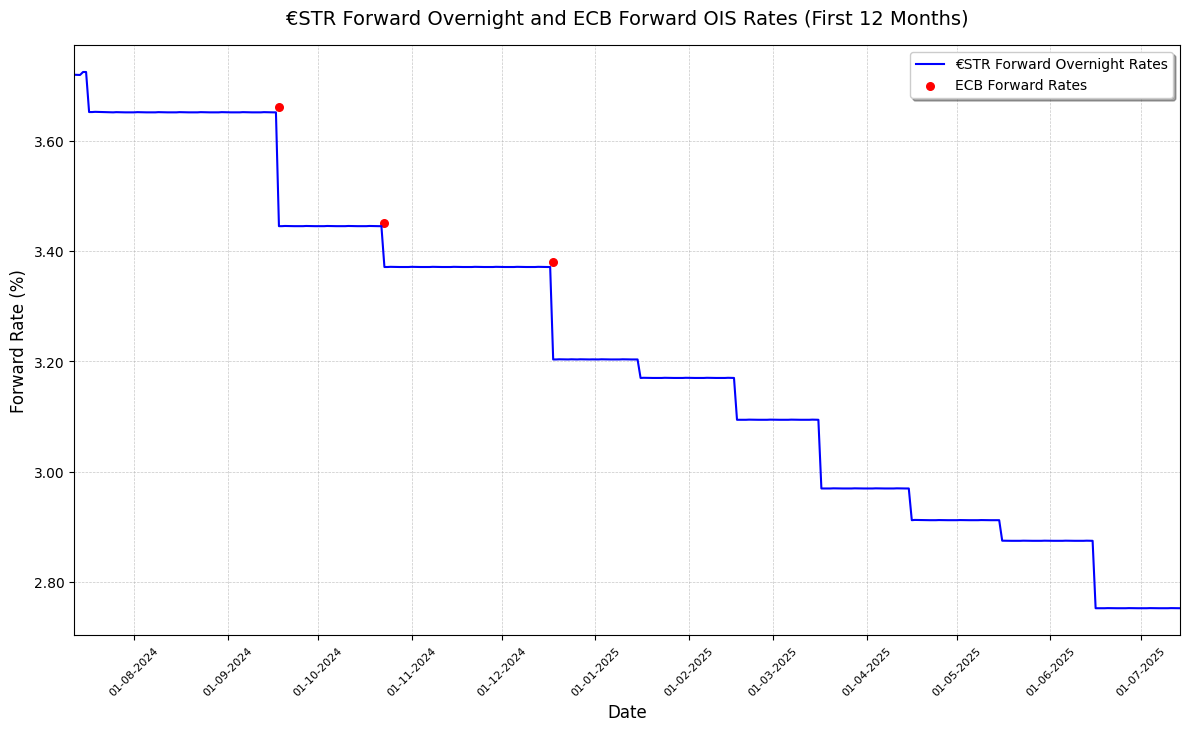

In [4]:
# To simplify analysis, we turn to flat forward rates instead of log-cubic discounts
estr_curve_ff = ql.PiecewiseFlatForward(
    0, ql.TARGET(), estr_helpers, ql.Actual365Fixed()
)
estr_curve_ff.enableExtrapolation()

# Restrict the plot to the first 12 months
end = ql.TARGET().advance(settle_date, ql.Period(12, ql.Months))

# Calculate the forward rates for the first 12 months
dates = [
    ql.Date(serial)
    for serial in range(settle_date.serialNumber(), end.serialNumber() + 1)
]

# Convert QuantLib dates to datetime
dates_dt = [d.to_date() for d in dates]

rates_ff = [
    estr_curve_ff.forwardRate(
        d, ql.TARGET().advance(d, 1, ql.Days), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]




# Convert QuantLib dates in 'Start_Period' to datetime objects
forwards_ois_ecb_data['End_Period_dt'] = forwards_ois_ecb_data['End_Period'].apply(_to_datetime)

# Convert ECB forward dates to datetime
ecb_forward_dates = forwards_ois_ecb_data['End_Period_dt'].tolist()

# Extract ECB forward rates from the 'Mid' column
ecb_forward_rates = forwards_ois_ecb_data['Mid'].values/100

plt.figure(figsize=(width, height))
rates_ff_percent = [rate * 100 for rate in rates_ff]
ecb_forward_rates_percent = [rate * 100 for rate in ecb_forward_rates]

plt.plot(dates_dt, rates_ff_percent, label='€STR Forward Overnight Rates', color='blue', linestyle='-', linewidth=1.5)
plt.scatter(ecb_forward_dates, ecb_forward_rates_percent, label='ECB Forward Rates', color='red', marker='o', s=30)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
plt.gca().tick_params(axis='x', labelsize=8, rotation=45)

plt.xlim(dates_dt[0], dates_dt[-1])
plt.xlabel('Date', fontsize=12)
plt.ylabel('Forward Rate (%)', fontsize=12)
plt.title('€STR Forward Overnight and ECB Forward OIS Rates (First 12 Months)', fontsize=14, pad=15)
plt.legend(loc='upper right', fontsize=10, frameon=True, shadow=True, fancybox=True)
plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.show()



The chart illustrates the €STR overnight forward rates and the ECB forward OIS rates for the first 12 months from July 12, 2024. The blue line shows the overnight forward rates, derived from the discount curve using the bootstrapping methodology outlined in this section. The red dots represent the ECB forward OIS rates, plotted at the end of each reserve maintenance period to which they refer, one day before the start of the subsequent one.

# Section 5: Construction of the 3-Month Euribor Curve - No Synthetic Deposits
In this section, we construct the 3-month Euribor curve without using synthetic deposits. This involves defining the 3-month Euribor instance, adding a 0x3M FRA, futures, and swap rate helpers, and building both the zero and forward curves. The forward curve is then plotted to visualize the 3-month Euribor rates.

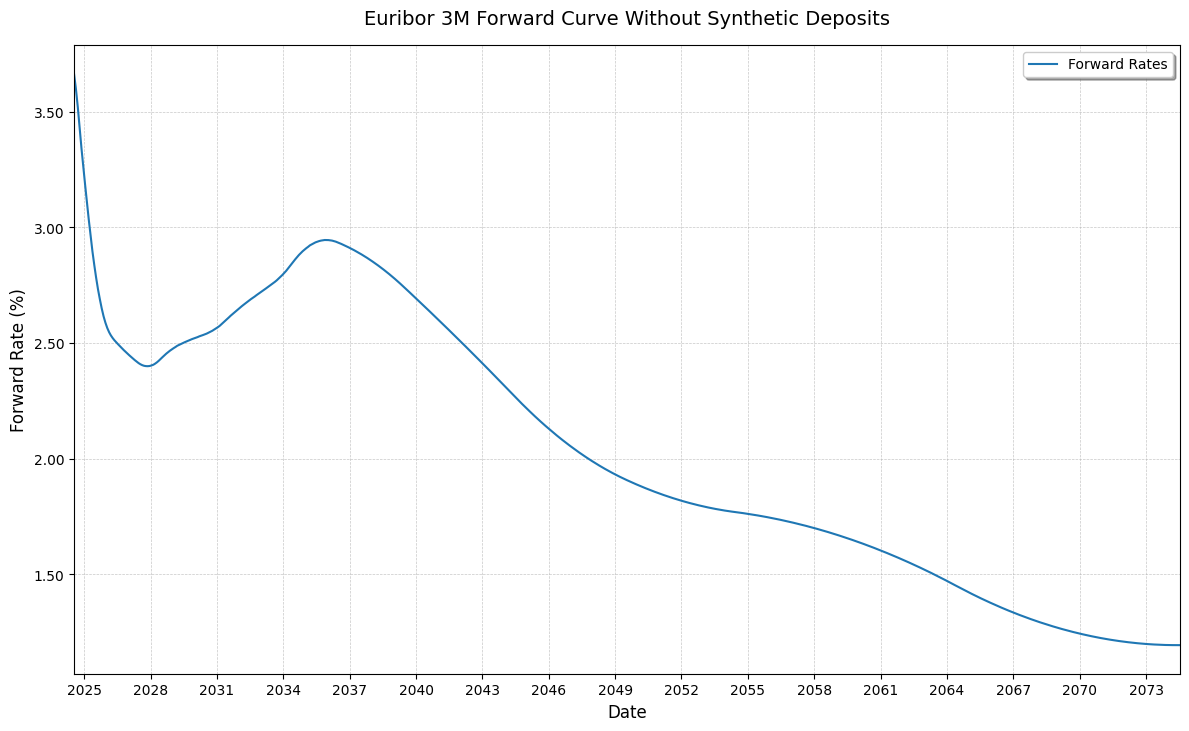

In [5]:
def euribor_curve_builder_no_synth_depo(
    estr_curve=estr_curve,
    fra_data3M=fra_data3M,
    futures_data3M=futures_data3M,
    swap_data3M=swap_data3M,
    futures_maturities_chosen=futures_maturities_chosen,
    swap_maturities_chosen=swap_maturities_chosen,
    dual_curve_approach=True,
    graph=True):

    # Define the 3-month Euribor instance
    euribor3m = ql.Euribor3M()

    # 1) 0x3 FRA
    # First pillar of the EURIBOR curve: the 0x3M FRA
    first_pillar_3m = fra_data3M[fra_data3M['Maturity'] == '0X3']

    fra_0x3_3m_helper = []
    fra_0x3_3m_helper.append(ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(first_pillar_3m['Mid'].values[0] / 100)),
                                     first_pillar_3m['Start_Period'].values[0], euribor3m))


    # 2) Futures
    # Add futures for the second part of the curve from selected FRA
    future_helpers = []
    selected_data = futures_data3M[futures_data3M['Maturity'].isin(futures_maturities_chosen)]
    for index, row in selected_data.iterrows():
        future_helpers.append(
            ql.FuturesRateHelper(
                ql.QuoteHandle(ql.SimpleQuote((row['Mid']))),
                row['Start_Date'],
                euribor3m,
                ql.QuoteHandle(),
            )
        )

    # Use €STR as the discount curve for the dual curve approach
    discount_curve = ql.YieldTermStructureHandle(estr_curve)

    
    # 3) Swaps
    # Add helpers for the third part of the curve from selected swaps
    swap_helpers = []
    selected_data = swap_data3M[swap_data3M['Maturity'].isin(swap_maturities_chosen)]

    if dual_curve_approach:
        for index, row in selected_data.iterrows():
            swap_helpers.append(ql.SwapRateHelper(
                ql.QuoteHandle(ql.SimpleQuote(row['Mid'] / 100)), row['Period'], ql.TARGET(), ql.Annual, ql.Unadjusted,
                ql.Thirty360(ql.Thirty360.BondBasis), euribor3m, ql.QuoteHandle(), ql.Period(0, ql.Days), discount_curve))
    else:
        for index, row in selected_data.iterrows():
            swap_helpers.append(ql.SwapRateHelper(
                ql.QuoteHandle(ql.SimpleQuote(row['Mid'] / 100)), row['Period'], ql.TARGET(), ql.Annual, ql.Unadjusted,
                ql.Thirty360(ql.Thirty360.BondBasis), euribor3m, ql.QuoteHandle(), ql.Period(0, ql.Days)))
            
    # Debug: Print details of all EURIBOR helpers
    DEBUG_EUR = False
    if DEBUG_EUR:
        for helper in fra_0x3_3m_helper + future_helpers + swap_helpers:
            helper_type = type(helper).__name__
            start_date = helper.earliestDate()
            maturity_date = helper.maturityDate()
            quote = helper.quote().value()
            print(f"Type: {helper_type}, Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")
            
    # Build the zero curve
    euribor3m_curve_no_synth_depo = ql.PiecewiseLogCubicDiscount(
        2, ql.TARGET(), fra_0x3_3m_helper + future_helpers + swap_helpers, ql.Actual365Fixed()
    )
    euribor3m_curve_no_synth_depo.enableExtrapolation()

    # Build the forward curve
    spot_date = euribor3m_curve_no_synth_depo.referenceDate()  # Set the evaluation date as the spot date
    dates = [spot_date + ql.Period(i, ql.Months) for i in range(0, 50 * 12 + 1)]
    dates_dt = [_to_datetime(date) for date in dates]

    euribor3m_f_curve_no_synth_depo = [
        euribor3m_curve_no_synth_depo.forwardRate(
            d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    # Plot the forward EURIBOR curve
    if graph:
        plt.figure(figsize=(width, height))
        euribor3m_f_curve_no_synth_depo_percent = [rate * 100 for rate in euribor3m_f_curve_no_synth_depo]
        plt.plot(dates_dt, euribor3m_f_curve_no_synth_depo_percent, label='Forward Rates', linewidth=1.5)
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
        plt.xlim([dates_dt[0], dates_dt[-1]])
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Forward Rate (%)', fontsize=12)
        plt.title('Euribor 3M Forward Curve Without Synthetic Deposits', fontsize=14, pad=15)
        plt.legend(loc='upper right', fontsize=10, frameon=True, shadow=True, fancybox=True)
        plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
        plt.tight_layout()
        plt.show()


    return euribor3m_curve_no_synth_depo, euribor3m_f_curve_no_synth_depo, fra_0x3_3m_helper, future_helpers, swap_helpers, spot_date, euribor3m

# Build the Euribor curve with no synthetic deposits
euribor3m_curve_no_synth_depo, euribor3m_f_curve_no_synth_depo, fra_0x3_3m_helper, future_helpers, swap_helpers_dual, spot_date, euribor3m = euribor_curve_builder_no_synth_depo()


Figure - The Euribor 3M forward curve constructed without the inclusion of synthetic deposits. The curve shows the forward rates from 2024 to 2084 based on a bootstrapping procedure that solely utilizes market instruments such as FRAs, Euribor futures, and swaps. The absence of synthetic deposits results in a less accurate representation of forward rate expectations in the initial part of the curve, where backward interpolation is applied.

# Section 6: Calculation of Basis and Creation of Synthetic Deposits
In this section, we calculate the basis (spread) between the forward 3-month EURIBOR and €STR rates. We then create synthetic deposit helpers for various short-term maturities by adjusting the €STR forward rates with the calculated spread. This process enables the construction of a more accurate 3-month EURIBOR curve.


In [6]:
def synthetic_deposit_builder(
    euribor3m_curve_no_synth_depo=euribor3m_curve_no_synth_depo,
    estr_curve=estr_curve,
    spot_date=spot_date,
    print_alpha=True):
    

# ATTENTION: since we are using a 0x3 FRA -> t1 = 0, so forward rate is equal to the zero rate.
    # Bootstrap the 0X3-month rate from the existing 3-month EURIBOR curve
    euribor3m_0X3M_rate = euribor3m_curve_no_synth_depo.forwardRate(
        spot_date, ql.TARGET().advance(spot_date, 3, ql.Months), ql.Actual360(), ql.Simple).rate()

    # Bootstrap the 0X3-month rate from the €STR curve
    estr_0X3M_rate = estr_curve.forwardRate(
        spot_date, ql.TARGET().advance(spot_date, 3, ql.Months), ql.Actual360(), ql.Simple).rate()

    # Calculate the spread (alpha) between the 3-month forward EURIBOR rate and the 3-month forward €STR rate
    alpha = euribor3m_0X3M_rate - estr_0X3M_rate

    if print_alpha:
        print(f"Alpha: {alpha}")     

    # Construct helpers for synthetic deposits
    synth_deposit_helper_ON_to_2M = []

    # Define a list of tuples representing the maturities for which synthetic deposits will be created
    # Each tuple contains a number (n) and a unit of time (Days, Weeks, Months)
    for n, units in [
        (1, ql.Days),
        (1, ql.Weeks),
        (2, ql.Weeks),
        (3, ql.Weeks),
        (1, ql.Months),
        (2, ql.Months),
    ]:
        # Calculate the synth deposits rates from the €STR curve for the given duration and adjust the Euribor rate by adding the previously calculated spread (alpha)
        estr_0Xx_3M_rate = estr_curve.forwardRate(
            spot_date, ql.TARGET().advance(spot_date, n, units), ql.Actual360(), ql.Simple
        ).rate()
        
        synth_euribor3m_deposit_rate = estr_0Xx_3M_rate + alpha

        # Create a synthetic deposit helper with the calculated forward rate and add it to the list
        synth_deposit_helper_ON_to_2M.append(
            ql.DepositRateHelper(
                ql.QuoteHandle(ql.SimpleQuote(synth_euribor3m_deposit_rate)),  # Adjusted forward rate
                ql.Period(n, units),  # Duration for the synthetic deposit
                2,  # Settlement days
                ql.TARGET(),  # Calendar
                ql.Following,  # Business day convention
                False,  # End of month flag
                ql.Actual360(),  # Day count convention
            )
        )

    # DEBUG: Print details of each synthetic deposit helper
    DEBUG_SYNTH = False
    if DEBUG_SYNTH:
        print("Synthetic Deposit Helpers:")
        for helper in synth_deposit_helper_ON_to_2M:
            helper_type = type(helper).__name__
            start_date = helper.earliestDate()
            maturity_date = helper.maturityDate()
            quote = helper.quote().value()
            print(f"Type: {helper_type}, Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")
            
    return synth_deposit_helper_ON_to_2M

# Build synthetic deposit helpers
synth_deposit_helper_ON_to_2M = synthetic_deposit_builder()


Alpha: 0.0005511863596106767


# Section 7: Construction of the Euribor 3M forward Curve with Synthetic Deposits
In this section, we construct the forward Euribor curve using synthetic deposits. We create a combined list of helpers, including synthetic deposits, a 0x3M FRA, futures, and swaps. This combined list is used to build the Euribor curve, which is then plotted to visualize the forward rates.

In [7]:
def euribor_curve_builder_with_synth_depo(
    synth_deposit_helper_ON_to_2M=synth_deposit_helper_ON_to_2M, 
    fra_0x3_3m_helper=fra_0x3_3m_helper,
    future_helpers=future_helpers, 
    swap_helpers_dual=swap_helpers_dual, 
    graph=True):
    
    # Construct the corrected EURIBOR curve using synthetic deposit helpers
    euribor3m_curve_with_synth_depo = ql.PiecewiseLogCubicDiscount(
        2, ql.TARGET(), synth_deposit_helper_ON_to_2M + fra_0x3_3m_helper + future_helpers + swap_helpers_dual, ql.Actual365Fixed()
    )
    euribor3m_curve_with_synth_depo.enableExtrapolation()

    # DEBUG: Print details of the corrected EURIBOR curve helpers
    DEBUG_EU_CORR = False
    if DEBUG_EU_CORR:
        print("Corrected Euribor Helpers:")
        for helper in synth_deposit_helper_ON_to_2M + fra_0x3_3m_helper + future_helpers + swap_helpers_dual:
            helper_type = type(helper).__name__
            start_date = helper.earliestDate()
            maturity_date = helper.maturityDate()
            quote = helper.quote().value()
            print(f"Helper Type: {helper_type}, Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")

    dates = [spot_date + ql.Period(i, ql.Months) for i in range(0, 50 * 12 + 1)]
    dates_dt = [_to_datetime(date) for date in dates]

    # Construct the corrected forward EURIBOR curve
    euribor3m_f_curve = [
        euribor3m_curve_with_synth_depo.forwardRate(
            d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

         
    # Display the 3M-Euribor curve instruments summary --------------------------------------------------------------
    synthetic_data_3m = None
    if graph:
        # For synthetic deposits, we only have helper data, so we extract it from the helpers
        synthetic_data_3m = pd.DataFrame({
            'Instrument': ['Synthetic Deposit'] * len(synth_deposit_helper_ON_to_2M),
            'Maturity': ['ON', '1W', '2W', '3W', '1M', '2M'],
            'Start Date': [helper.earliestDate() for helper in synth_deposit_helper_ON_to_2M],
            'Maturity Date': [helper.maturityDate() for helper in synth_deposit_helper_ON_to_2M],
            'Bid': [''] * len(synth_deposit_helper_ON_to_2M),  
            'Ask': [''] * len(synth_deposit_helper_ON_to_2M),
            'Mid': [helper.quote().value()*100 for helper in synth_deposit_helper_ON_to_2M]
        })

        # Combine with other instrument data
        combined_data_euribor3m = pd.concat([
            synthetic_data_3m,  # Include synthetic deposits
            fra_data3M[fra_data3M['Maturity'] == '0X3'].assign(Instrument='FRA'),
            futures_data3M[futures_data3M['Maturity'].isin(futures_maturities_chosen)].assign(Instrument='Futures'),
            swap_data3M[swap_data3M['Maturity'].isin(swap_maturities_chosen)].assign(Instrument='Swap')
        ]).reset_index(drop=True)  # Reset the index here
        

        # Set Tenor based on available information
        combined_data_euribor3m['Tenor'] = combined_data_euribor3m['Maturity']

        # Extract start_date and maturity_date from all helpers
        start_dates = []
        maturity_dates = []
        
        for helper in synth_deposit_helper_ON_to_2M + fra_0x3_3m_helper + future_helpers + swap_helpers_dual:
            start_dates.append(helper.earliestDate())
            maturity_dates.append(helper.maturityDate())

        combined_data_euribor3m['Start Date'] = start_dates
        combined_data_euribor3m['Maturity Date'] = maturity_dates

        # Reorder columns
        euribor3m_data_table = combined_data_euribor3m[['Instrument', 'Tenor', 'Start Date', 'Maturity Date', 'Bid', 'Ask', 'Mid']]

        # Round values to three decimal places
        euribor3m_data_table = euribor3m_data_table.round(3)

        # Display the DataFrame
        print("3M-Euribor Curve Instruments Summary:")
        display(euribor3m_data_table)
    #--------------------------------------------------------------

    return euribor3m_curve_with_synth_depo, euribor3m_f_curve, synthetic_data_3m



euribor3m_curve_with_synth_depo, euribor3m_f_curve, synthetic_data_3m = euribor_curve_builder_with_synth_depo()


3M-Euribor Curve Instruments Summary:


Instrument Tenor            Start Date         Maturity Date   
0   Synthetic Deposit    ON       July 16th, 2024       July 17th, 2024  \
1   Synthetic Deposit    1W       July 16th, 2024       July 23rd, 2024   
2   Synthetic Deposit    2W       July 16th, 2024       July 30th, 2024   
3   Synthetic Deposit    3W       July 16th, 2024      August 6th, 2024   
4   Synthetic Deposit    1M       July 16th, 2024     August 16th, 2024   
5   Synthetic Deposit    2M       July 16th, 2024  September 16th, 2024   
6                 FRA   0X3       July 16th, 2024    October 16th, 2024   
7             Futures  DEC4   December 18th, 2024      March 18th, 2025   
8             Futures  MAR5      March 19th, 2025       June 19th, 2025   
9             Futures  JUN5       June 18th, 2025  September 18th, 2025   
10            Futures  SEP5  September 17th, 2025   December 17th, 2025   
11            Futures  DEC5   December 17th, 2025      March 17th, 2026   
12            Futures  MAR6      March 18th, 2026       June 18th, 2026   
13               Swap    3Y       July 16th, 2024       July 16th, 2027   
14               Swap    4Y       July 16th, 2024       July 17th, 2028   
15               Swap    5Y       July 16th, 2024       July 16th, 2029   
16               Swap    6Y       July 16th, 2024       July 16th, 2030   
17               Swap    7Y       July 16th, 2024       July 16th, 2031   
18               Swap    8Y       July 16th, 2024       July 16th, 2032   
19               Swap    9Y       July 16th, 2024       July 18th, 2033   
20               Swap   10Y       July 16th, 2024       July 17th, 2034   
21               Swap   12Y       July 16th, 2024       July 16th, 2036   
22               Swap   15Y       July 16th, 2024       July 18th, 2039   
23               Swap   20Y       July 16th, 2024       July 18th, 2044   
24               Swap   25Y       July 16th, 2024       July 16th, 2049   
25               Swap   30Y       July 16th, 2024       July 16th, 2054   
26               Swap   40Y       July 16th, 2024       July 16th, 2064   
27               Swap   50Y       July 16th, 2024       July 16th, 2074   

       Bid     Ask     Mid  
0                    3.780  
1                    3.719  
2                    3.712  
3                    3.719  
4                    3.730  
5                    3.723  
6    3.654   3.674   3.664  
7    96.74  96.745  96.742  
8    96.97  96.975  96.972  
9   97.165   97.17  97.168  
10   97.31  97.315  97.312  
11   97.41  97.415  97.412  
12  97.465   97.47  97.468  
13   2.856   2.897   2.876  
14   2.778   2.782   2.780  
15   2.728   2.732   2.730  
16   2.704   2.708   2.706  
17   2.693   2.697   2.695  
18   2.695   2.699   2.697  
19   2.705   2.709   2.707  
20   2.718   2.722   2.720  
21   2.739    2.78   2.760  
22   2.768   2.809   2.788  
23   2.726   2.767   2.746  
24    2.63   2.671   2.650  
25   2.535   2.576   2.556  
26   2.382   2.423   2.402  
27    2.24   2.281   2.261

# Section 8: Comparing Forward Euribor Curves With and Without Synthetic Deposits

In this section, we conduct a detailed analysis of the Euribor forward curves, comparing the effects of including synthetic deposits versus excluding them. By calculating forward rates for both approaches, we aim to understand how synthetic deposits influence the short-term rate projections. The analysis includes a focused comparison of the first 6 months to highlight short-term impacts. The plots visually depict the difference between the two methods, with annotations indicating the basis point differences in the short-term curves, thus offering insights into the effects of synthetic deposits on forward rate estimations.

C:\Users\djlor\AppData\Local\Temp\ipykernel_19560\2167876826.py:41: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


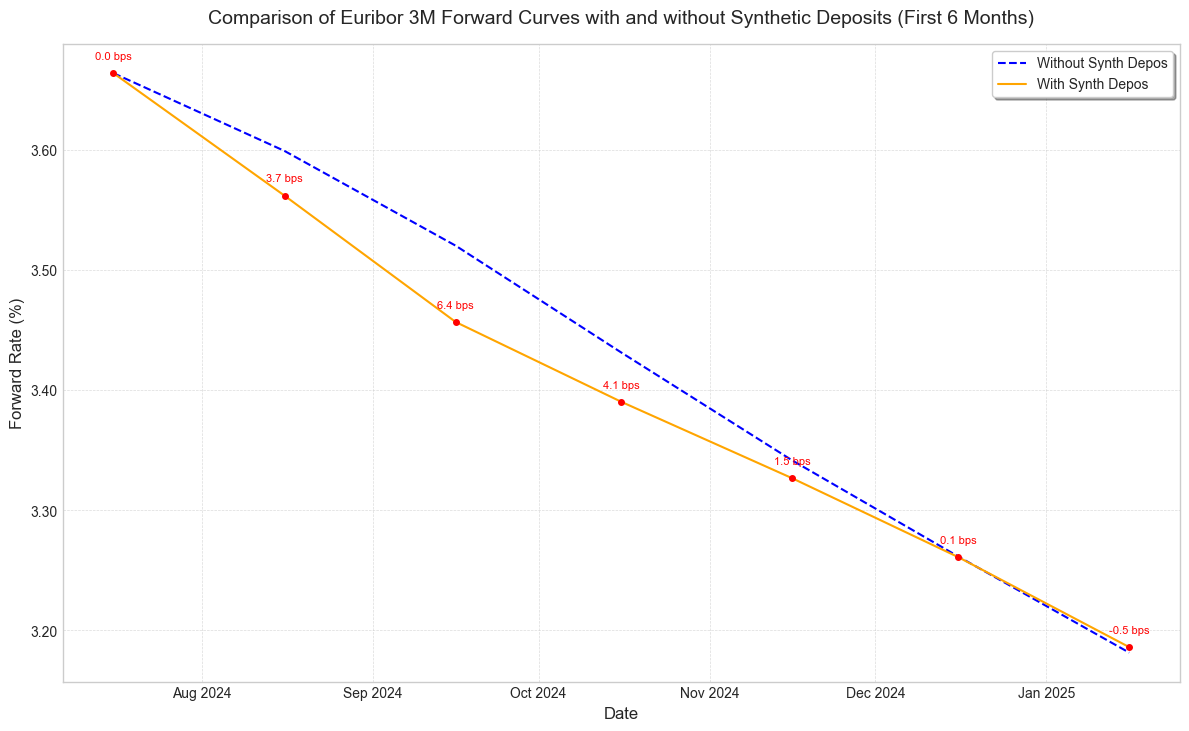

In [8]:


# Calculate dates for 50 years and first 6 months
dates = [spot_date + ql.Period(i, ql.Months) for i in range(0, 50 * 12 + 1)]
dates_6m = [spot_date + ql.Period(i, ql.Months) for i in range(0, 6 + 1)]
dates_dt = [_to_datetime(date) for date in dates]
dates_dt_6m = [_to_datetime(date) for date in dates_6m]

# Calculate forward rates without synthetic deposits for 50 years
euribor3m_f_curve_no_synth_depo = [
    euribor3m_curve_no_synth_depo.forwardRate(
        d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

# Calculate forward rates with synthetic deposits for 50 years
euribor3m_f_curve = [
    euribor3m_curve_with_synth_depo.forwardRate(
        d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

# Calculate forward rates without synthetic deposits for the first 6 months
euribor3m_f_curve_no_synth_depo_first6m = [
    euribor3m_curve_no_synth_depo.forwardRate(
        d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates_6m
]

# Calculate forward rates with synthetic deposits for the first 6 months
euribor3m_f_curve_first6m = [
    euribor3m_curve_with_synth_depo.forwardRate(
        d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates_6m
]

# Plot: Overlapping Curves for the First 6 Months
# Set the plot style for a clean aesthetic
plt.style.use('seaborn-whitegrid')

# Create the figure 
plt.figure(figsize=(width, height))
euribor3m_f_curve_no_synth_depo_first6m_percent = [rate * 100 for rate in euribor3m_f_curve_no_synth_depo_first6m]
euribor3m_f_curve_first6m_percent = [rate * 100 for rate in euribor3m_f_curve_first6m]
plt.plot(dates_dt_6m, euribor3m_f_curve_no_synth_depo_first6m_percent, label='Without Synth Depos', color='blue', linestyle='--', linewidth=1.5)
plt.plot(dates_dt_6m, euribor3m_f_curve_first6m_percent, label='With Synth Depos', color='orange', linestyle='-', linewidth=1.5)
plt.title('Comparison of Euribor 3M Forward Curves with and without Synthetic Deposits (First 6 Months)', fontsize=14, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Forward Rate (%)', fontsize=12)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
plt.legend(loc='upper right', fontsize=10, frameon=True, shadow=True, fancybox=True)

# Annotate differences in basis points every 1 month
interval = 1  # Annotate every 1 month
for i in range(0, len(dates_dt_6m), interval):
    date = dates_dt_6m[i]
    rate_no_synth = euribor3m_f_curve_no_synth_depo_first6m_percent[i]
    rate_with_synth = euribor3m_f_curve_first6m_percent[i]
    diff = rate_no_synth - rate_with_synth
    diff_bps = diff * 100  # Convert difference to basis points (already in percentage)
    plt.annotate(f'{diff_bps:.1f} bps',
                 (date, rate_with_synth),
                 textcoords="offset points",
                 xytext=(0, 10),
                 ha='center',
                 fontsize=8,
                 color='red')

# Add markers to indicate annotation points
plt.plot(dates_dt_6m[::interval], euribor3m_f_curve_first6m_percent[::interval], 'o', color='red', markersize=4)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the third plot
plt.show()

Figure - Comparison of the Euribor 3M forward curves with and without synthetic deposits over the first 6 Months. The blue dashed line depicts the forward curve constructed without synthetic deposits, while the orange solid line represents the forward curve with synthetic deposits included. Red markers and annotations indicate the basis point (bps) differences at key points along the curves, demonstrating how the non-inclusion of synthetic deposits causes distortion in the estimation of the shortest forward rates.

# Section 9: Comparison of Dual Curve and Single euribor3m Forward Curves - Discounting impact
In this section, we construct the EURIBOR curves using both single and dual curve approaches. The EURIBOR 3-month zero curve is created using swap helpers, synthetic deposit helpers, a 0x3M FRA, and futures helpers. The dual curve approach captures market conditions accurately, while the single curve approach allows direct comparison without dual calibration. We plot both zero and forward rates, annotating differences in basis points to highlight how future rate expectations diverge over time.

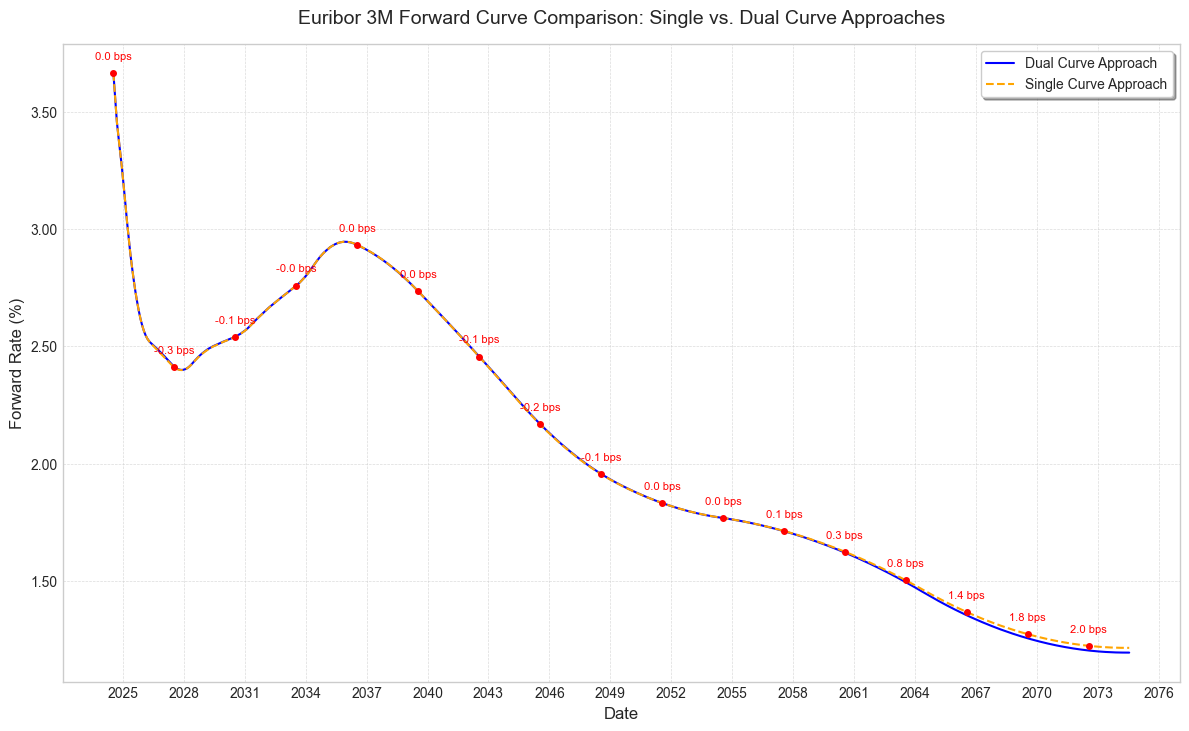

In [9]:
#Set the evaluation date for the curves
dates = [spot_date + ql.Period(i, ql.Months) for i in range(0, 50 * 12 + 1)]
dates_dt = [_to_datetime(date) for date in dates]

# Construct the Euribor zero curve 
euribor3m_zero_rates = [
    euribor3m_curve_with_synth_depo.zeroRate(date, ql.Actual365Fixed(), ql.Continuous).rate()
    for date in dates
]

# Construct the Euribor curve with single curve approach
_,_,_,_, swap_helpers_single,*_ =   euribor_curve_builder_no_synth_depo(
                                    dual_curve_approach=False,
                                    graph=False)

euribor3m_curve_single = ql.PiecewiseLogCubicDiscount(
    2, ql.TARGET(), synth_deposit_helper_ON_to_2M + fra_0x3_3m_helper + future_helpers + swap_helpers_single, ql.Actual365Fixed()
)
euribor3m_curve_single.enableExtrapolation()

# Calculate zero rates for the single curve approach
euribor3m_zero_rates_single = [
    euribor3m_curve_single.zeroRate(date, ql.Actual365Fixed(), ql.Continuous).rate()
    for date in dates
]

# Construct the forward curve for the single curve approach
euribor3m_f_curve_single = [
    euribor3m_curve_single.forwardRate(
        d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

# First plot: €STR Zero Rates + euribor3m Zero Curves (Single vs Dual Approach)

# Create a new figure
plt.figure(figsize=(width, height))

# Calculate the values in percentage
estr_zero_rates_percent = [rate * 100 for rate in estr_zero_rates]
euribor3m_zero_rates_percent = [rate * 100 for rate in euribor3m_zero_rates]
euribor3m_zero_rates_single_percent = [rate * 100 for rate in euribor3m_zero_rates_single]

# Plot
plt.plot(dates_dt, estr_zero_rates_percent, label='€STR Zero Rates', color='green', linewidth=1.5)
plt.plot(dates_dt, euribor3m_zero_rates_percent, label='Euribor 3M Zero Curve (Dual Curve Approach)', color='blue', linewidth=1.5)
plt.plot(dates_dt, euribor3m_zero_rates_single_percent, label='Euribor 3M Zero Curve (Single Curve Approach)', color='orange', linewidth=1.5)
plt.title('Euribor 3M Zero Curve: Single vs. Dual Curve Approaches', fontsize=14, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Zero Rate (%)', fontsize=12)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
plt.legend(loc='upper right', fontsize=10, frameon=True, shadow=True, fancybox=True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

# Second plot: Forward Curves for Single vs Dual Approach with Annotations

# Create a new figure
plt.figure(figsize=(width, height))

# Calculate the values in percentage
euribor3m_f_curve_percent = [rate * 100 for rate in euribor3m_f_curve]
euribor3m_f_curve_single_percent = [rate * 100 for rate in euribor3m_f_curve_single]

# Plot
plt.plot(dates_dt, euribor3m_f_curve_percent, label='Dual Curve Approach', color='blue', linewidth=1.5)
plt.plot(dates_dt, euribor3m_f_curve_single_percent, label='Single Curve Approach', color='orange', linestyle='--', linewidth=1.5)
plt.title('Euribor 3M Forward Curve Comparison: Single vs. Dual Curve Approaches', fontsize=14, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Forward Rate (%)', fontsize=12)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))

# Add annotations
interval = 36  # Annotate every 36 months (3 years)
for i in range(0, len(dates_dt), interval):
    date = dates_dt[i]
    rate_dual = euribor3m_f_curve_percent[i]
    rate_single = euribor3m_f_curve_single_percent[i]
    diff = rate_single - rate_dual
    diff_bps = diff * 100  # Convert difference to basis points (already in percentage)
    plt.annotate(f'{diff_bps:.1f} bps',
                 (date, rate_single),
                 textcoords="offset points",
                 xytext=(0, 10),
                 ha='center',
                 fontsize=8,
                 color='red')

# Add markers to indicate annotation points
plt.plot(dates_dt[::interval], euribor3m_f_curve_single_percent[::interval], 'o', color='red', markersize=4)

# Add grid, legend, and display the plot
plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
plt.legend(loc='upper right', fontsize=10, frameon=True, shadow=True, fancybox=True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

Figure 1 - Comparison of Euribor 3M and €STR Zero Curves constructed using single vs dual curve approaches. The green line represents the €STR zero curve, serving as  benchmark for comparison. The blue line shows the Euribor 3M zero curve built using the dual-curve approach, where an exogenous discounting rate is applied from the €STR curve. The orange line depicts the Euribor 3M zero curve built with the single-curve approach, where both projection and discounting are based on the Euribor curve itself.

Figure 2 - Comparison of the Euribor 3M forward curves derived using single vs dual curve approaches over the entire maturity horizon. The blue solid line represents the forward rates generated using the dual-curve methodology, while the orange dashed line shows the rates from the single-curve approach. The red markers and annotations indicate the basis point (bps) differences at key points along the forward curves.

# Section 10: Construction of the Euribor6M Forward Curve and comparison with the euribor3m Forward Curve - The importance of being tenor consistent
In this section, we construct the forward Euribor6M curve using the dual curve approach. We then compare the Euribor6M forward curve with the euribor3m forward curve to identify any differences between the two curves.

Euribor 6M Curve Instruments Summary:


Instrument  Tenor            Start Date         Maturity Date   
0   Synthetic Deposit     ON       July 16th, 2024       July 17th, 2024  \
1   Synthetic Deposit     1W       July 16th, 2024       July 23rd, 2024   
2   Synthetic Deposit     2W       July 16th, 2024       July 30th, 2024   
3   Synthetic Deposit     3W       July 16th, 2024      August 6th, 2024   
4   Synthetic Deposit     1M       July 16th, 2024     August 16th, 2024   
5   Synthetic Deposit     2M       July 16th, 2024  September 16th, 2024   
6   Synthetic Deposit     3M       July 16th, 2024    October 16th, 2024   
7   Synthetic Deposit     4M       July 16th, 2024   November 18th, 2024   
8   Synthetic Deposit     5M       July 16th, 2024   December 16th, 2024   
9                 FRA    0X6       July 16th, 2024    January 16th, 2025   
10                FRA    1X7     August 16th, 2024   February 17th, 2025   
11                FRA    2X8  September 16th, 2024      March 17th, 2025   
12                FRA    3X9    October 16th, 2024      April 16th, 2025   
13                FRA   4X10   November 18th, 2024        May 16th, 2025   
14                FRA   5X11   December 16th, 2024       June 16th, 2025   
15                FRA   6X12    January 16th, 2025       July 16th, 2025   
16                FRA   7X13   February 17th, 2025     August 18th, 2025   
17                FRA   8X14      March 17th, 2025  September 16th, 2025   
18                FRA   9X15      April 16th, 2025    October 16th, 2025   
19                FRA  10X16        May 16th, 2025   November 17th, 2025   
20                FRA  11X17       June 16th, 2025   December 16th, 2025   
21                FRA  12X18       July 16th, 2025    January 16th, 2026   
22                FRA  18X24    January 16th, 2026       July 16th, 2026   
23               Swap     3Y       July 16th, 2024       July 16th, 2027   
24               Swap     4Y       July 16th, 2024       July 17th, 2028   
25               Swap     5Y       July 16th, 2024       July 16th, 2029   
26               Swap     6Y       July 16th, 2024       July 16th, 2030   
27               Swap     7Y       July 16th, 2024       July 16th, 2031   
28               Swap     8Y       July 16th, 2024       July 16th, 2032   
29               Swap     9Y       July 16th, 2024       July 18th, 2033   
30               Swap    10Y       July 16th, 2024       July 17th, 2034   
31               Swap    12Y       July 16th, 2024       July 16th, 2036   
32               Swap    15Y       July 16th, 2024       July 18th, 2039   
33               Swap    20Y       July 16th, 2024       July 18th, 2044   
34               Swap    25Y       July 16th, 2024       July 16th, 2049   
35               Swap    30Y       July 16th, 2024       July 16th, 2054   
36               Swap    40Y       July 16th, 2024       July 16th, 2064   
37               Swap    50Y       July 16th, 2024       July 16th, 2074   

       Bid     Ask    Mid  
0                   3.903  
1                   3.841  
2                   3.835  
3                   3.842  
4                   3.853  
5                   3.845  
6                   3.786  
7                   3.743  
8                   3.711  
9    3.652   3.672  3.662  
10   3.553   3.573  3.563  
11   3.453   3.473  3.463  
12   3.368   3.388  3.378  
13   3.281   3.301  3.291  
14   3.206   3.226  3.216  
15   3.134   3.154  3.144  
16   3.059   3.079  3.069  
17    2.99    3.01  3.000  
18   2.928   2.948  2.938  
19   2.874   2.894  2.884  
20   2.816   2.836  2.826  
21   2.774   2.794  2.784  
22   2.577   2.597  2.587  
23   2.935   2.945  2.940  
24   2.841   2.851  2.846  
25   2.787   2.797  2.792  
26   2.759   2.769  2.764  
27   2.745   2.755  2.750  
28   2.739   2.749  2.744  
29   2.745   2.755  2.750  
30   2.749   2.759  2.754  
31   2.769   2.779  2.774  
32   2.786   2.796  2.791  
33   2.718   2.728  2.723  
34  2.6025  2.6325  2.617  
35   2.506   2.516  2.511  
36   2.326

C:\Users\djlor\AppData\Local\Temp\ipykernel_19560\2078958537.py:167: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


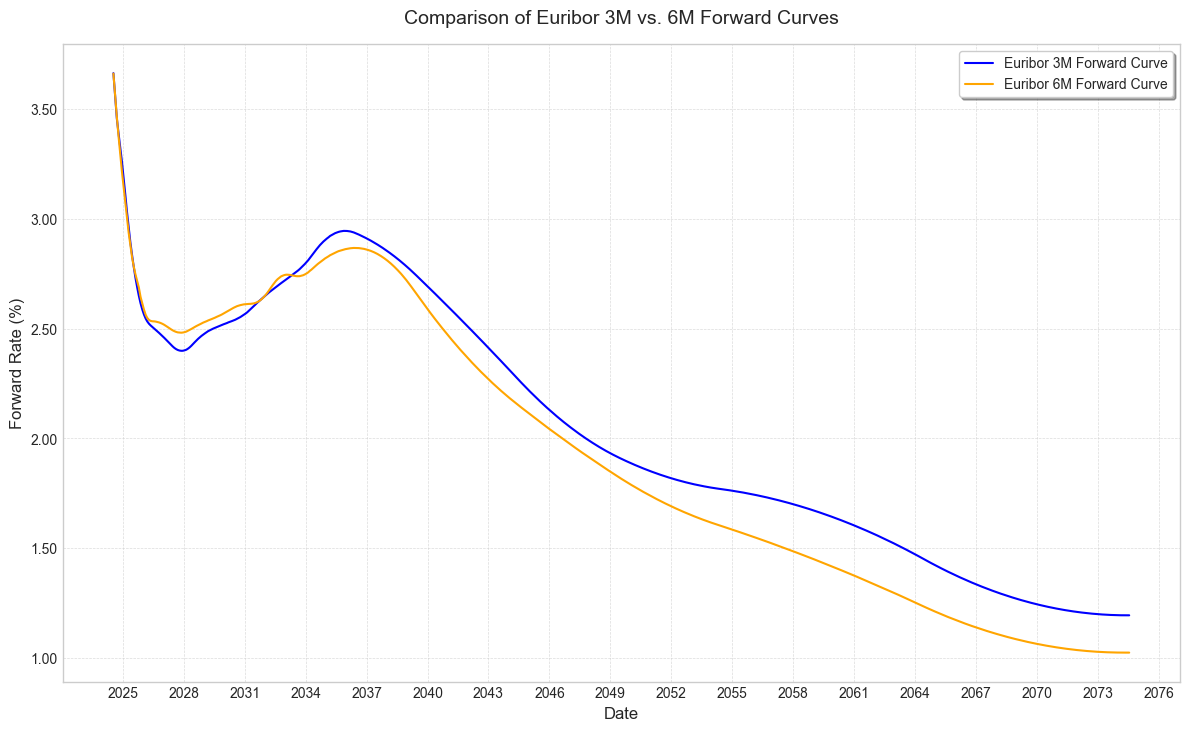

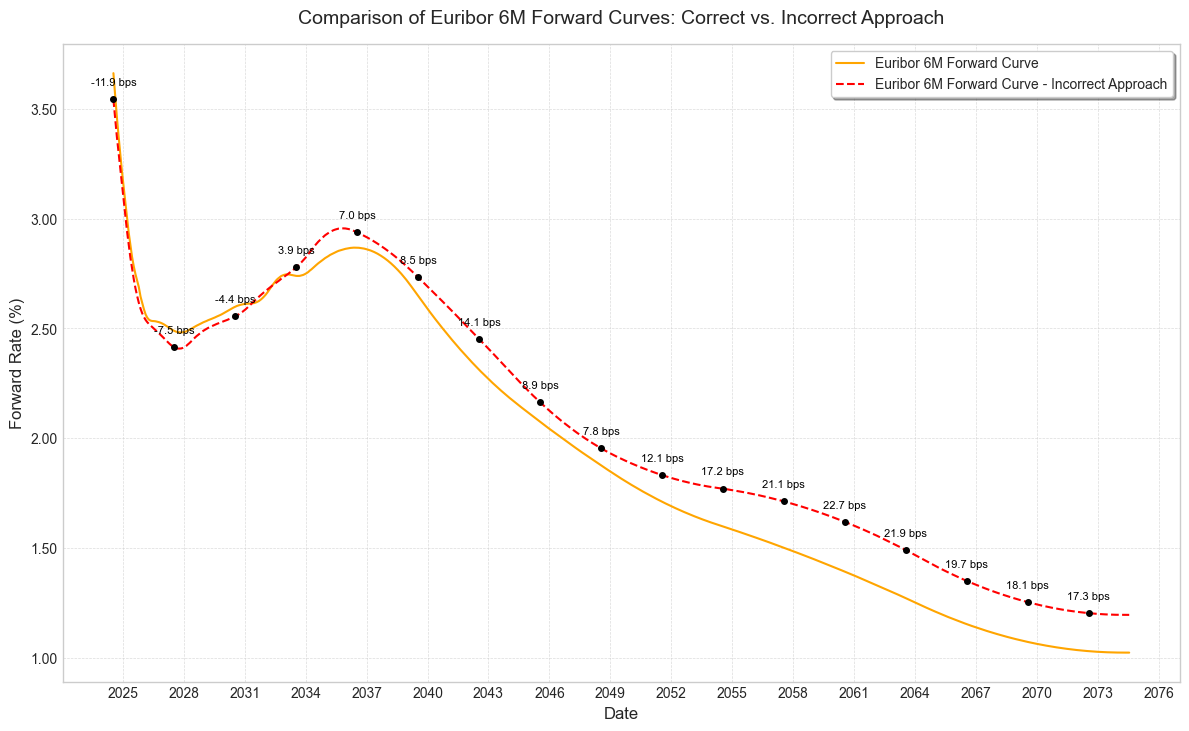

In [10]:
euribor6m = ql.Euribor6M()
# 1 & 2) FRA 0x6 + other FRAs

fra_helpers_6m = []
for index, row in fra_data6M.iterrows():
    fra_helpers_6m.append(ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(row['Mid'] / 100)),
                                     row['Start_Period'], euribor6m))

discount_curve = ql.YieldTermStructureHandle(estr_curve)

# 3) SWAP
# Aggiungo gli helpers per la terza parte della curva dai SWAP
swap_helpers_6m = []
selected_data = swap_data6M[swap_data6M['Maturity'].isin(swap_maturities_chosen)]
for index, row in selected_data.iterrows():
    swap_helpers_6m.append(ql.SwapRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row['Mid'] / 100)), row['Period'], ql.TARGET(), ql.Annual, ql.Unadjusted,
        ql.Thirty360(ql.Thirty360.BondBasis), euribor6m, ql.QuoteHandle(), ql.Period(0, ql.Days), discount_curve))

# Build the zero curve
euribor6m_curve_no_synth_depo = ql.PiecewiseLogCubicDiscount(
    2, ql.TARGET(), fra_helpers_6m + swap_helpers_6m, ql.Actual365Fixed()
)
euribor6m_curve_no_synth_depo.enableExtrapolation()

#======================build and add synthetic deposits====================

# Set the spot date to one day after the settlement date (fixing convention)
d = ql.TARGET().advance(spot_date, 1, ql.Days)

# Bootsrap del tasso forward a 6 mesi dalla curva EURIBOR a 6 mesi preesistente
euribor6m_forward_curve_no_synth_depo = euribor6m_curve_no_synth_depo.forwardRate(
    d, ql.TARGET().advance(d, 6, ql.Months), ql.Actual360(), ql.Simple).rate()

# Bootstrap the forward 6-month rate from the existing 6-month EURIBOR curve
euribor6m_0X6M_rate = euribor6m_curve_no_synth_depo.forwardRate(
    spot_date, ql.TARGET().advance(spot_date, 6, ql.Months), ql.Actual360(), ql.Simple).rate()

# Bootstrap the forward 6-month rate from the €STR curve
estr_0X6M_rate = estr_curve.forwardRate(
    d, ql.TARGET().advance(d, 6, ql.Months), ql.Actual360(), ql.Simple).rate()

# Calculate the spread (alpha) between the 6-month forward EURIBOR rate and the 3-month forward €STR rate
alpha = euribor6m_0X6M_rate - estr_0X6M_rate

# Construct helpers for synthetic deposits
synth_deposit_helper_ON_to_5M = []

for n, units in [
    (1, ql.Days),
    (1, ql.Weeks),
    (2, ql.Weeks),
    (3, ql.Weeks),
    (1, ql.Months),
    (2, ql.Months),
    (3, ql.Months),
    (4, ql.Months),
    (5, ql.Months),
]:
        # Calculate the forward rate from the €STR curve for the given duration and adjust the Euribor forward rate by adding the previously calculated spread (alpha)
    estr_0Xx_6M_rate = estr_curve.forwardRate(
        spot_date, ql.TARGET().advance(spot_date, n, units), ql.Actual360(), ql.Simple
    ).rate()
    
    synth_euribor6M_0Xx__deposit_rate = estr_0Xx_6M_rate + alpha

    # Create a synthetic deposit helper with the calculated forward rate and add it to the list
    synth_deposit_helper_ON_to_5M.append(
        ql.DepositRateHelper(
            ql.QuoteHandle(ql.SimpleQuote(synth_euribor6M_0Xx__deposit_rate)),  # Adjusted forward rate
            ql.Period(n, units),  # Duration for the synthetic deposit
            2,  # Settlement days
            ql.TARGET(),  # Calendar
            ql.Following,  # Business day convention
            False,  # End of month flag
            ql.Actual360(),  # Day count convention
        )
    )

euribor6m_curve = ql.PiecewiseLogCubicDiscount(
    2, ql.TARGET(), synth_deposit_helper_ON_to_5M + fra_helpers_6m + swap_helpers_6m, ql.Actual365Fixed()
)
euribor6m_curve.enableExtrapolation()


# DEBUG: Print details of each synthetic deposit helper
DEBUG_6M = False
if DEBUG_6M:
    print("Euribor 6M Helpers:")
    for helper in synth_deposit_helper_ON_to_5M + fra_helpers_6m + swap_helpers_6m:
        helper_type = type(helper).__name__
        start_date = helper.earliestDate()
        maturity_date = helper.maturityDate()
        quote = helper.quote().value()
        print(f"Type: {helper_type}, Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")



# Build the forward curve
euribor6m_f_curve = [
    euribor6m_curve.forwardRate(
        d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

# Calculate the forward rates using the wrong approach
euribor6m_f_curve_wrong = [
    euribor3m_curve_with_synth_depo.forwardRate(
        d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]


#--------------------------------------------------------------
# Display the instruments in the 6M-Euribor curve


synthetic_data_6m = pd.DataFrame({
    'Instrument': ['Synthetic Deposit'] * len(synth_deposit_helper_ON_to_5M),
    'Maturity': ['ON', '1W', '2W', '3W', '1M', '2M', '3M', '4M', '5M'],
    'Start Date': [helper.earliestDate() for helper in synth_deposit_helper_ON_to_5M],
    'Maturity Date': [helper.maturityDate() for helper in synth_deposit_helper_ON_to_5M],
    'Bid': [''] * len(synth_deposit_helper_ON_to_5M),  
    'Ask': [''] * len(synth_deposit_helper_ON_to_5M),
    'Mid': [helper.quote().value()*100 for helper in synth_deposit_helper_ON_to_5M]
})


# Combine with other instrument data
combined_data_euribor6m = pd.concat([
    synthetic_data_6m,  # Include synthetic deposits
    fra_data6M.assign(Instrument='FRA'),
    swap_data6M[swap_data6M['Maturity'].isin(swap_maturities_chosen)].assign(Instrument='Swap')
]).reset_index(drop=True)  # Reset the index here


# Set Tenor based on available information
combined_data_euribor6m['Tenor'] = combined_data_euribor6m['Maturity']

# Extract start_date and maturity_date from all helpers
start_dates = []
maturity_dates = []

for helper in synth_deposit_helper_ON_to_5M + fra_helpers_6m + swap_helpers_6m:
    start_dates.append(helper.earliestDate())
    maturity_dates.append(helper.maturityDate())

combined_data_euribor6m['Start Date'] = start_dates
combined_data_euribor6m['Maturity Date'] = maturity_dates

# Reorder columns
data_table_euribor6m = combined_data_euribor6m[['Instrument', 'Tenor', 'Start Date', 'Maturity Date', 'Bid', 'Ask', 'Mid']]

# Round values to three decimal places
data_table_euribor6m = data_table_euribor6m.round(3)

# Display the DataFrame
print("Euribor 6M Curve Instruments Summary:")
display(data_table_euribor6m)
#--------------------------------------------------------------

#Plots

# Set up the plot style
plt.style.use('seaborn-whitegrid')

# Calculate the values in percentage
euribor3m_f_curve_percent = [rate * 100 for rate in euribor3m_f_curve]
euribor6m_f_curve_percent = [rate * 100 for rate in euribor6m_f_curve]
euribor6m_f_curve_wrong_percent = [rate * 100 for rate in euribor6m_f_curve_wrong]

# Create figure for the first plot
plt.figure(figsize=(width, height))

# Plot 1: Euribor 3M vs 6M Forward Curves
plt.plot(dates_dt, euribor3m_f_curve_percent, label='Euribor 3M Forward Curve', color='blue', linewidth=1.5)
plt.plot(dates_dt, euribor6m_f_curve_percent, label='Euribor 6M Forward Curve', color='orange', linewidth=1.5)
plt.title('Comparison of Euribor 3M vs. 6M Forward Curves', fontsize=14, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Forward Rate (%)', fontsize=12)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
plt.legend(loc='upper right', fontsize=10, frameon=True, shadow=True, fancybox=True)

# Display the first plot
plt.tight_layout()
plt.show()

# Create figure for the second plot
plt.figure(figsize=(width, height))

# Plot 2: Euribor 6M Forward Curve vs. Incorrect Approach
plt.plot(dates_dt, euribor6m_f_curve_percent, label='Euribor 6M Forward Curve', color='orange', linewidth=1.5)
plt.plot(dates_dt, euribor6m_f_curve_wrong_percent, label='Euribor 6M Forward Curve - Incorrect Approach', color='red', linestyle='--', linewidth=1.5)
plt.title('Comparison of Euribor 6M Forward Curves: Correct vs. Incorrect Approach', fontsize=14, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Forward Rate (%)', fontsize=12)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
plt.legend(loc='upper right', fontsize=10, frameon=True, shadow=True, fancybox=True)

# Annotate differences in basis points between the correct and wrong 6M forward curves
interval = 36  # Annotate every 36 months (3 years)
for i in range(0, len(dates_dt), interval):
    date = dates_dt[i]
    rate_correct = euribor6m_f_curve_percent[i]
    rate_wrong = euribor6m_f_curve_wrong_percent[i]
    diff = rate_wrong - rate_correct
    diff_bps = diff * 100  # Convert difference to basis points (already in percentage)
    plt.annotate(f'{diff_bps:.1f} bps',
                 (date, rate_wrong),
                 textcoords="offset points",
                 xytext=(0, 10),
                 ha='center',
                 fontsize=8,
                 color='black')

# Add markers to indicate annotation points
plt.plot(dates_dt[::interval], euribor6m_f_curve_wrong_percent[::interval], 'o', color='black', markersize=4)

# Display the second plot
plt.tight_layout()
plt.show()



Figure 1 - Comparison of Euribor 3M and 6M forward Curves. The blue line represents the forward curve constructed for Euribor 3M, while the orange line represents the Euribor 6M forward curve.

Figure 2 - Comparison between correctly and incorrectly constructed Euribor 6M forward curves. The correct approach (orange) uses tenor-consistent instruments, while the incorrect approach (red dashed) employs instruments with a 3-month tenor.

# Section 11: Constructing and Evaluating Euribor 3M Forward Curves via Diverse Bootstrapping Instrument Configurations
In this section, we develop and evaluate euribor3m forward curves utilizing various bootstrapping instrument configurations to assess their impact on curve construction. We investigate four distinct combinations that incorporate different financial instruments, such as synthetic deposits, futures, FRAs, and swaps, each tailored to focus on specific market dynamics. Through a dual curve approach, each combination is crafted to examine the sensitivity and robustness of the forward curve under different market assumptions. These curves are then systematically plotted, allowing for a comparative analysis of their structural variations and forward rate projections over a 50-year horizon, thereby elucidating the strategic implications of each bootstrapping methodology on curve modeling.

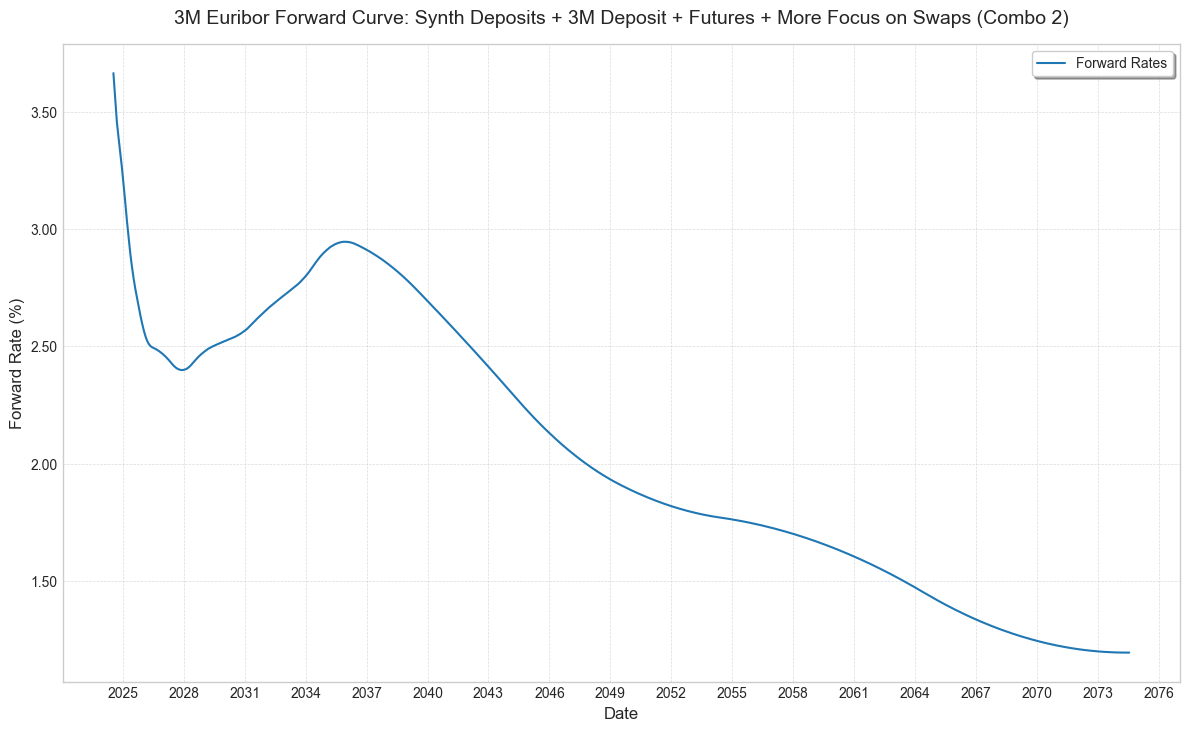

3M-Euribor Curve Instruments Summary (Combo 2):


Instrument Tenor           Start Date         Maturity Date   
0   Synthetic Deposit    ON      July 16th, 2024       July 17th, 2024  \
1   Synthetic Deposit    1W      July 16th, 2024       July 23rd, 2024   
2   Synthetic Deposit    2W      July 16th, 2024       July 30th, 2024   
3   Synthetic Deposit    3W      July 16th, 2024      August 6th, 2024   
4   Synthetic Deposit    1M      July 16th, 2024     August 16th, 2024   
5   Synthetic Deposit    2M      July 16th, 2024  September 16th, 2024   
6                 FRA   0X3      July 16th, 2024    October 16th, 2024   
7             Futures  DEC4  December 18th, 2024      March 18th, 2025   
8             Futures  MAR5     March 19th, 2025       June 19th, 2025   
9             Futures  JUN5      June 18th, 2025  September 18th, 2025   
10               Swap   18M      July 16th, 2024    January 16th, 2026   
11               Swap    2Y      July 16th, 2024       July 16th, 2026   
12               Swap    3Y      July 16th, 2024       July 16th, 2027   
13               Swap    4Y      July 16th, 2024       July 17th, 2028   
14               Swap    5Y      July 16th, 2024       July 16th, 2029   
15               Swap    6Y      July 16th, 2024       July 16th, 2030   
16               Swap    7Y      July 16th, 2024       July 16th, 2031   
17               Swap    8Y      July 16th, 2024       July 16th, 2032   
18               Swap    9Y      July 16th, 2024       July 18th, 2033   
19               Swap   10Y      July 16th, 2024       July 17th, 2034   
20               Swap   12Y      July 16th, 2024       July 16th, 2036   
21               Swap   15Y      July 16th, 2024       July 18th, 2039   
22               Swap   20Y      July 16th, 2024       July 18th, 2044   
23               Swap   25Y      July 16th, 2024       July 16th, 2049   
24               Swap   30Y      July 16th, 2024       July 16th, 2054   
25               Swap   40Y      July 16th, 2024       July 16th, 2064   
26               Swap   50Y      July 16th, 2024       July 16th, 2074   

       Bid     Ask     Mid  
0                    3.780  
1                    3.719  
2                    3.712  
3                    3.719  
4                    3.730  
5                    3.723  
6    3.654   3.674   3.664  
7    96.74  96.745  96.742  
8    96.97  96.975  96.972  
9   97.165   97.17  97.168  
10   3.171   3.211   3.191  
11   3.043   3.049   3.046  
12   2.856   2.897   2.876  
13   2.778   2.782   2.780  
14   2.728   2.732   2.730  
15   2.704   2.708   2.706  
16   2.693   2.697   2.695  
17   2.695   2.699   2.697  
18   2.705   2.709   2.707  
19   2.718   2.722   2.720  
20   2.739    2.78   2.760  
21   2.768   2.809   2.788  
22   2.726   2.767   2.746  
23    2.63   2.671   2.650  
24   2.535   2.576   2.556  
25   2.382   2.423   2.402  
26    2.24   2.281   2.261

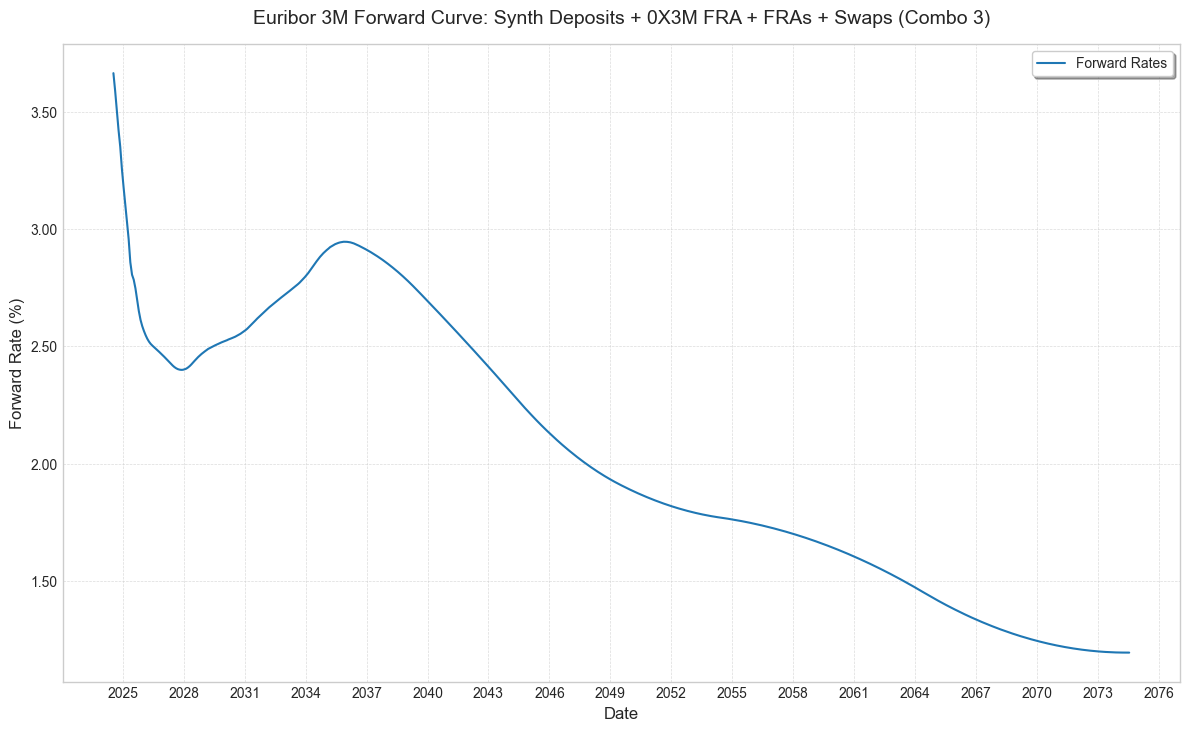

Euribor 3M Curve Instruments Summary (Combo 3):


Instrument  Tenor            Start Date         Maturity Date   
0   Synthetic Deposit     ON       July 16th, 2024       July 17th, 2024  \
1   Synthetic Deposit     1W       July 16th, 2024       July 23rd, 2024   
2   Synthetic Deposit     2W       July 16th, 2024       July 30th, 2024   
3   Synthetic Deposit     3W       July 16th, 2024      August 6th, 2024   
4   Synthetic Deposit     1M       July 16th, 2024     August 16th, 2024   
5   Synthetic Deposit     2M       July 16th, 2024  September 16th, 2024   
6                 FRA    0X3       July 16th, 2024    October 16th, 2024   
7                 FRA    1X4     August 16th, 2024   November 18th, 2024   
8                 FRA    2X5  September 16th, 2024   December 16th, 2024   
9                 FRA    3X6    October 16th, 2024    January 16th, 2025   
10                FRA    4X7   November 18th, 2024   February 17th, 2025   
11                FRA    5X8   December 16th, 2024      March 17th, 2025   
12                FRA    6X9    January 16th, 2025      April 16th, 2025   
13                FRA   7X10   February 17th, 2025        May 16th, 2025   
14                FRA   8X11      March 17th, 2025       June 16th, 2025   
15                FRA   9X12      April 16th, 2025       July 16th, 2025   
16                FRA  12X15       July 16th, 2025    October 16th, 2025   
17                FRA  15X18    October 16th, 2025    January 16th, 2026   
18                FRA  18X21    January 16th, 2026      April 16th, 2026   
19                FRA  21X24      April 16th, 2026       July 16th, 2026   
20               Swap     3Y       July 16th, 2024       July 16th, 2027   
21               Swap     4Y       July 16th, 2024       July 17th, 2028   
22               Swap     5Y       July 16th, 2024       July 16th, 2029   
23               Swap     6Y       July 16th, 2024       July 16th, 2030   
24               Swap     7Y       July 16th, 2024       July 16th, 2031   
25               Swap     8Y       July 16th, 2024       July 16th, 2032   
26               Swap     9Y       July 16th, 2024       July 18th, 2033   
27               Swap    10Y       July 16th, 2024       July 17th, 2034   
28               Swap    12Y       July 16th, 2024       July 16th, 2036   
29               Swap    15Y       July 16th, 2024       July 18th, 2039   
30               Swap    20Y       July 16th, 2024       July 18th, 2044   
31               Swap    25Y       July 16th, 2024       July 16th, 2049   
32               Swap    30Y       July 16th, 2024       July 16th, 2054   
33               Swap    40Y       July 16th, 2024       July 16th, 2064   
34               Swap    50Y       July 16th, 2024       July 16th, 2074   

      Bid    Ask    Mid  
0                 3.780  
1                 3.719  
2                 3.712  
3                 3.719  
4                 3.730  
5                 3.723  
6   3.654  3.674  3.664  
7   3.579  3.599  3.589  
8    3.49   3.52  3.505  
9   3.412  3.432  3.422  
10   3.33   3.36  3.345  
11   3.24   3.27  3.255  
12   3.16   3.19  3.175  
13  3.089  3.109  3.099  
14   3.02   3.04  3.030  
15  2.947  2.967  2.957  
16  2.774  2.794  2.784  
17  2.625  2.675  2.650  
18   2.54   2.59  2.565  
19  2.495  2.545  2.520  
20  2.856  2.897  2.876  
21  2.778  2.782  2.780  
22  2.728  2.732  2.730  
23  2.704  2.708  2.706  
24  2.693  2.697  2.695  
25  2.695  2.699  2.697  
26  2.705  2.709  2.707  
27  2.718  2.722  2.720  
28  2.739   2.78  2.760  
29  2.768  2.809  2.788  
30  2.726  2.767  2.746  
31   2.63  2.671  2.650  
32  2.535  2.576  2.556  
33  2.382  2.423  2.402  
34   2.24  2.281  2.261

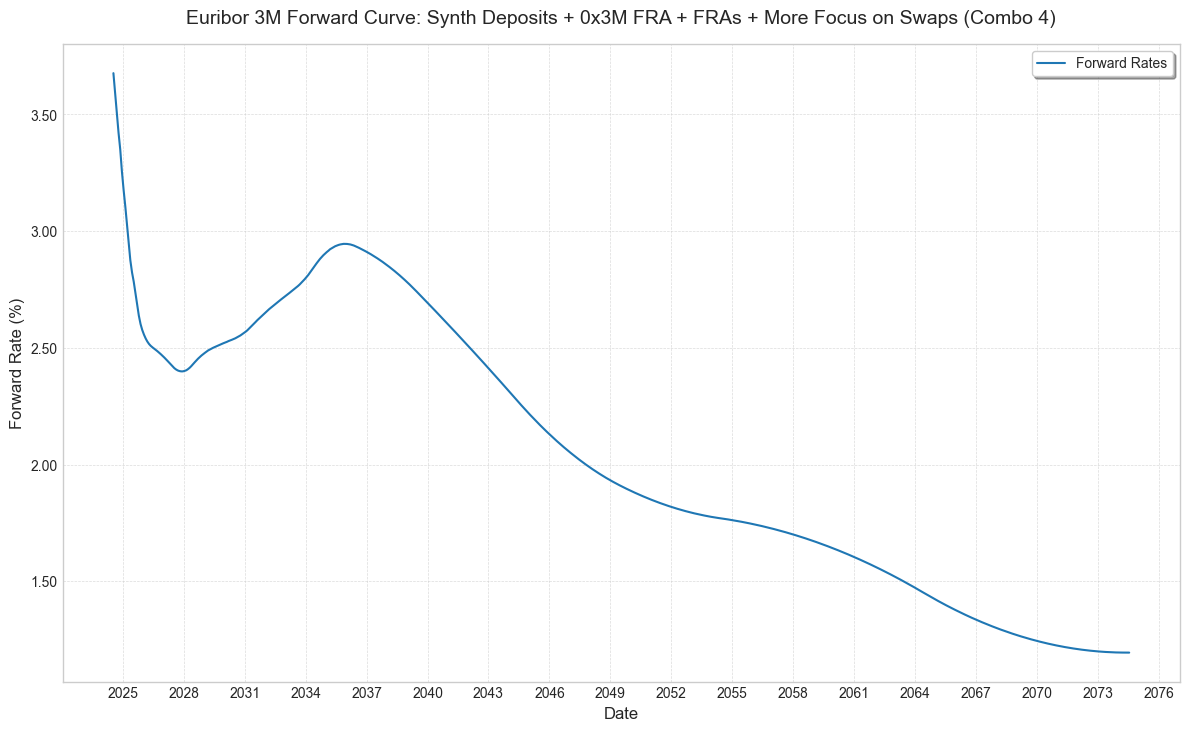

3M-Euribor Curve Instruments Summary (Combo 4):


Instrument  Tenor            Start Date         Maturity Date   
0   Synthetic Deposit     ON       July 16th, 2024       July 17th, 2024  \
1   Synthetic Deposit     1W       July 16th, 2024       July 23rd, 2024   
2   Synthetic Deposit     2W       July 16th, 2024       July 30th, 2024   
3   Synthetic Deposit     3W       July 16th, 2024      August 6th, 2024   
4   Synthetic Deposit     1M       July 16th, 2024     August 16th, 2024   
5   Synthetic Deposit     2M       July 16th, 2024  September 16th, 2024   
6                 FRA    1X4     August 16th, 2024   November 18th, 2024   
7                 FRA    2X5  September 16th, 2024   December 16th, 2024   
8                 FRA    3X6    October 16th, 2024    January 16th, 2025   
9                 FRA    4X7   November 18th, 2024   February 17th, 2025   
10                FRA    5X8   December 16th, 2024      March 17th, 2025   
11                FRA    6X9    January 16th, 2025      April 16th, 2025   
12                FRA   7X10   February 17th, 2025        May 16th, 2025   
13                FRA   8X11      March 17th, 2025       June 16th, 2025   
14                FRA   9X12      April 16th, 2025       July 16th, 2025   
15                FRA  12X15       July 16th, 2025    October 16th, 2025   
16               Swap    18M       July 16th, 2024    January 16th, 2026   
17               Swap     2Y       July 16th, 2024       July 16th, 2026   
18               Swap     3Y       July 16th, 2024       July 16th, 2027   
19               Swap     4Y       July 16th, 2024       July 17th, 2028   
20               Swap     5Y       July 16th, 2024       July 16th, 2029   
21               Swap     6Y       July 16th, 2024       July 16th, 2030   
22               Swap     7Y       July 16th, 2024       July 16th, 2031   
23               Swap     8Y       July 16th, 2024       July 16th, 2032   
24               Swap     9Y       July 16th, 2024       July 18th, 2033   
25               Swap    10Y       July 16th, 2024       July 17th, 2034   
26               Swap    12Y       July 16th, 2024       July 16th, 2036   
27               Swap    15Y       July 16th, 2024       July 18th, 2039   
28               Swap    20Y       July 16th, 2024       July 18th, 2044   
29               Swap    25Y       July 16th, 2024       July 16th, 2049   
30               Swap    30Y       July 16th, 2024       July 16th, 2054   
31               Swap    40Y       July 16th, 2024       July 16th, 2064   
32               Swap    50Y       July 16th, 2024       July 16th, 2074   

      Bid    Ask    Mid  
0                 3.780  
1                 3.719  
2                 3.712  
3                 3.719  
4                 3.730  
5                 3.723  
6   3.579  3.599  3.589  
7    3.49   3.52  3.505  
8   3.412  3.432  3.422  
9    3.33   3.36  3.345  
10   3.24   3.27  3.255  
11   3.16   3.19  3.175  
12  3.089  3.109  3.099  
13   3.02   3.04  3.030  
14  2.947  2.967  2.957  
15  2.774  2.794  2.784  
16  3.171  3.211  3.191  
17  3.043  3.049  3.046  
18  2.856  2.897  2.876  
19  2.778  2.782  2.780  
20  2.728  2.732  2.730  
21  2.704  2.708  2.706  
22  2.693  2.697  2.695  
23  2.695  2.699  2.697  
24  2.705  2.709  2.707  
25  2.718  2.722  2.720  
26  2.739   2.78  2.760  
27  2.768  2.809  2.788  
28  2.726  2.767  2.746  
29   2.63  2.671  2.650  
30  2.535  2.576  2.556  
31  2.382  2.423  2.402  
32   2.24  2.281  2.261

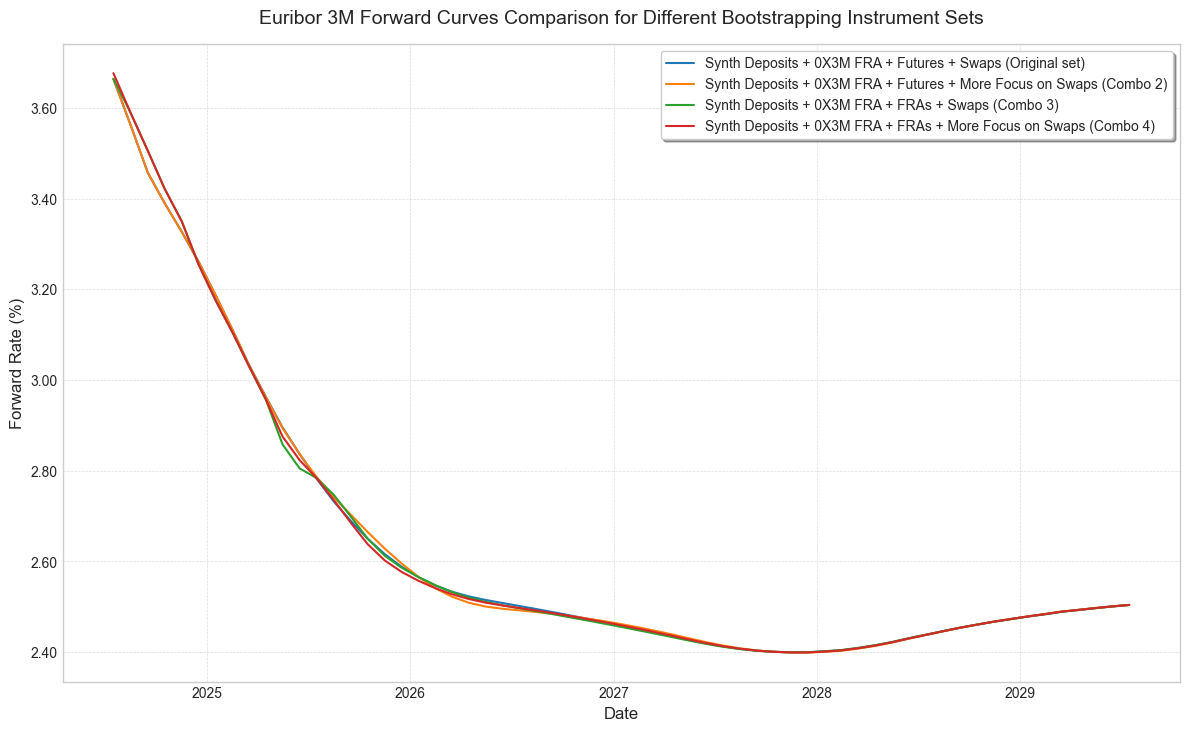

In [11]:
def different_i_b_sets_curves_builder(
    synth_deposit_helper_ON_to_2M=synth_deposit_helper_ON_to_2M, 
    fra_0x3_3m_helper=fra_0x3_3m_helper,
    swap_helpers_dual=swap_helpers_dual, 
    estr_curve=estr_curve,
    euribor3m_curve_with_synth_depo=euribor3m_curve_with_synth_depo,
    futures_data3M=futures_data3M,
    swap_data3M=swap_data3M, 
    fra_data3M=fra_data3M,
    synthetic_data_3m=synthetic_data_3m,
    graph=True, 
    graph_comparison=True):

    ## Combination 2: Greater focus on swaps ===============================================================================================================
    futures_maturities_chosen_combo2 = ['DEC4', 'MAR5', 'JUN5'] # We cannot reduce the maturities of the futures further or the algorithm will not converge
    focus_swap_maturities_chosen = ['18M','2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '12Y', '15Y', '20Y', '25Y', '30Y', '40Y', '50Y']

    # The 0x3M FRA and SYNTHETIC DEPOSITS are the same as in combination 1

    # FUTURES
    selected_data = futures_data3M[futures_data3M['Maturity'].isin(futures_maturities_chosen_combo2)]
    futures_helpers_combo2 = []
    for index, row in selected_data.iterrows():
        futures_helpers_combo2.append(
            ql.FuturesRateHelper(
                ql.QuoteHandle(ql.SimpleQuote((row['Mid']))),
                row['Start_Date'],
                euribor3m,
                ql.QuoteHandle(),
            )
        )

    # SWAPS
    discount_curve = ql.YieldTermStructureHandle(estr_curve)
    focus_swap_helpers = []
    selected_data = swap_data3M[swap_data3M['Maturity'].isin(focus_swap_maturities_chosen)]
    for index, row in selected_data.iterrows():
        focus_swap_helpers.append(ql.SwapRateHelper(
            ql.QuoteHandle(ql.SimpleQuote(row['Mid'] / 100)), 
            row['Period'], 
            ql.TARGET(), 
            ql.Annual, 
            ql.Unadjusted,
            ql.Thirty360(ql.Thirty360.BondBasis), 
            euribor3m, 
            ql.QuoteHandle(), 
            ql.Period(0, ql.Days), 
            discount_curve))
        
    # DEBUG: Print details of EURIBOR combo 2 helpers
    DEBUG_EU_COMBO2 = False
    if DEBUG_EU_COMBO2:
        print("Euribor combo 2 helpers:")
        for helper in synth_deposit_helper_ON_to_2M + fra_0x3_3m_helper + futures_helpers_combo2 + focus_swap_helpers:
            helper_type = type(helper).__name__
            start_date = helper.earliestDate()
            maturity_date = helper.maturityDate()
            quote = helper.quote().value()
            print(f"Type: {helper_type}, Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")

    # Build the curve
    all_helpers_combo2 = synth_deposit_helper_ON_to_2M + fra_0x3_3m_helper + futures_helpers_combo2 + focus_swap_helpers 

    euribor3m_curve_combo2 = ql.PiecewiseLogCubicDiscount(
        2, ql.TARGET(), all_helpers_combo2, ql.Actual365Fixed()
    )
    euribor3m_curve_combo2.enableExtrapolation()

    # Build the forward curve
    dates = [spot_date + ql.Period(i, ql.Months) for i in range(0, 50 * 12 + 1)]
    dates_dt = [_to_datetime(date) for date in dates]

    euribor3m_f_curve_combo2 = [
        euribor3m_curve_combo2.forwardRate(
            d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    # Plot the forward curve and display the instruments in the combo 2--------------------------------------------------------------
    if graph:
        plt.figure(figsize=(width, height))
        euribor3m_f_curve_combo2_percent = [rate * 100 for rate in euribor3m_f_curve_combo2]
    
        # Plot the data
        plt.plot(dates_dt, euribor3m_f_curve_combo2_percent, label='Forward Rates', linewidth=1.5)
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Forward Rate (%)', fontsize=12)
        plt.title('3M Euribor Forward Curve: Synth Deposits + 3M Deposit + Futures + More Focus on Swaps (Combo 2)', fontsize=14, pad=15)
        plt.legend(loc='upper right', fontsize=10, frameon=True, shadow=True, fancybox=True)
        plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
        plt.tight_layout()
        plt.show()

        # Create a DataFrame to display the instruments in the combo 2
        combined_data_combo2 = pd.concat([
            synthetic_data_3m.assign(Instrument='Synthetic Deposit'),
            fra_data3M[fra_data3M['Maturity'] == '0X3'].assign(Instrument='FRA'),  
            futures_data3M[futures_data3M['Maturity'].isin(futures_maturities_chosen_combo2)].assign(Instrument='Futures'),
            swap_data3M[swap_data3M['Maturity'].isin(focus_swap_maturities_chosen)].assign(Instrument='Swap'),
        ]).reset_index(drop=True)  # Reset the index here


        # Set Tenor based on available information
        combined_data_combo2['Tenor'] = combined_data_combo2['Maturity']

        # Extract start_date and maturity_date from all helpers
        start_dates = []
        maturity_dates = []

        for helper in synth_deposit_helper_ON_to_2M + fra_0x3_3m_helper + futures_helpers_combo2 + focus_swap_helpers:
            start_dates.append(helper.earliestDate())
            maturity_dates.append(helper.maturityDate())

        combined_data_combo2['Start Date'] = start_dates
        combined_data_combo2['Maturity Date'] = maturity_dates

        # Reorder columns
        data_table_combo2 = combined_data_combo2[['Instrument', 'Tenor', 'Start Date', 'Maturity Date', 'Bid', 'Ask', 'Mid']]

        # Round values to three decimal places
        data_table_combo2 = data_table_combo2.round(3)

        # Display the DataFrame
        print("3M-Euribor Curve Instruments Summary (Combo 2):")
        display(data_table_combo2)
    
    ## Combination 3: SYNTH DEPOSITIS, FRA and SWAPS ==============================================================================================================
    
    # Synth depos, the 0x3M FRA and SWAPS are the same as in combination 1

    # FRA
    fra_helpers_combo3 = []
    for index, row in fra_data3M.iterrows():
        fra_helpers_combo3.append(ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(row['Mid'] / 100)),
                                        row['Start_Period'], euribor3m))

    DEBUG_EU_COMBO3 = False
    if DEBUG_EU_COMBO3:
        print("Euribor combo 3 helpers:")
        for helper in synth_deposit_helper_ON_to_2M + fra_helpers_combo3 + swap_helpers_dual:
            helper_type = type(helper).__name__
            start_date = helper.earliestDate()
            maturity_date = helper.maturityDate()
            quote = helper.quote().value()
            print(f"Type: {helper_type}, Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")
            
    # Build the curve
    all_helpers_combo3 = synth_deposit_helper_ON_to_2M + fra_helpers_combo3 + swap_helpers_dual

    euribor3m_curve_combo3 = ql.PiecewiseLogCubicDiscount(
        2, ql.TARGET(), all_helpers_combo3, ql.Actual365Fixed()
    )

    euribor3m_curve_combo3.enableExtrapolation()

    # Build the forward curve
    euribor3m_f_curve_combo3 = [
        euribor3m_curve_combo3.forwardRate(
            d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    # Plot the forward curve and display the instruments --------------------------------------------------------------
    if graph:
        plt.figure(figsize=(width, height))
        euribor3m_f_curve_combo3_percent = [rate * 100 for rate in euribor3m_f_curve_combo3]
        plt.plot(dates_dt, euribor3m_f_curve_combo3_percent, label='Forward Rates', linewidth=1.5)
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Forward Rate (%)', fontsize=12)
        plt.title('Euribor 3M Forward Curve: Synth Deposits + 0X3M FRA + FRAs + Swaps (Combo 3)', fontsize=14, pad=15)
        plt.legend(loc='upper right', fontsize=10, frameon=True, shadow=True, fancybox=True)
        plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
        plt.tight_layout()
        plt.show()

        # Create a DataFrame to display the instruments in the combo 3
        combined_data_combo3 = pd.concat([
            synthetic_data_3m.assign(Instrument='Synthetic Deposit'),
            fra_data3M.assign(Instrument='FRA'),  
            swap_data3M[swap_data3M['Maturity'].isin(swap_maturities_chosen)].assign(Instrument='Swap'),
        ]).reset_index(drop=True)  # Reset the index here

        # Set Tenor based on available information
        combined_data_combo3['Tenor'] = combined_data_combo3['Maturity']

        # Extract start_date and maturity_date from all helpers
        start_dates = []
        maturity_dates = []

        for helper in synth_deposit_helper_ON_to_2M + fra_helpers_combo3 + swap_helpers_dual:
            start_dates.append(helper.earliestDate())
            maturity_dates.append(helper.maturityDate())

        combined_data_combo3['Start Date'] = start_dates
        combined_data_combo3['Maturity Date'] = maturity_dates

        # Reorder columns
        data_table_combo3 = combined_data_combo3[['Instrument', 'Tenor', 'Start Date', 'Maturity Date', 'Bid', 'Ask', 'Mid']]
        
        # Round values to three decimal places
        data_table_combo3 = data_table_combo3.round(3)

        # Display the DataFrame
        print("Euribor 3M Curve Instruments Summary (Combo 3):")
        display(data_table_combo3)




    # Combination 4: FRA with focus on swaps ==============================================================================================================

    fra3M_maturities_chosen_combo4 = ['0x3','1X4','2X5','3X6','4X7','5X8','6X9','7X10','8X11','9X12','10X13','12X15']

    # Synth depos and the 0x3 FRA are the same as in combination 1. Swasp are the same as in combination 2

    # FRA
    fra_helpers_combo4 = []
    selected_data = fra_data3M[fra_data3M['Maturity'].isin(fra3M_maturities_chosen_combo4)]
    for index, row in selected_data.iterrows():
        fra_helpers_combo4.append(ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(row['Mid'] / 100)),
                                        row['Start_Period'], euribor3m))

    DEBUG_EU_COMBO4 = False
    if DEBUG_EU_COMBO4:
        print("Euribor combo 4 helpers:")
        for helper in synth_deposit_helper_ON_to_2M + fra_helpers_combo4 + focus_swap_helpers:
            helper_type = type(helper).__name__
            start_date = helper.earliestDate()
            maturity_date = helper.maturityDate()
            quote = helper.quote().value()
            print(f"Type: {helper_type}, Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")
            
    # Build the EURIBOR curve
    all_helpers_combo4 = synth_deposit_helper_ON_to_2M + fra_helpers_combo4 + focus_swap_helpers

    euribor3m_curve_combo4 = ql.PiecewiseLogCubicDiscount(
        2, ql.TARGET(), all_helpers_combo4, ql.Actual365Fixed()
    )

    euribor3m_curve_combo4.enableExtrapolation()

    # Build the EURIBOR forward curve
    euribor3m_f_curve_combo4 = [
        euribor3m_curve_combo4.forwardRate(
            d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    # Plot the forward curve and display the instruments --------------------------------------------------------------
    if graph:
        plt.figure(figsize=(width, height))
        euribor3m_f_curve_combo4_percent = [rate * 100 for rate in euribor3m_f_curve_combo4]
        plt.plot(dates_dt, euribor3m_f_curve_combo4_percent, label='Forward Rates', linewidth=1.5)
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Forward Rate (%)', fontsize=12)
        plt.title('Euribor 3M Forward Curve: Synth Deposits + 0x3M FRA + FRAs + More Focus on Swaps (Combo 4)', fontsize=14, pad=15)
        plt.legend(loc='upper right', fontsize=10, frameon=True, shadow=True, fancybox=True)
        plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
        plt.tight_layout()
        plt.show()

        # Create a DataFrame to display the instruments in the combo 4
        combined_data_combo4 = pd.concat([
            synthetic_data_3m.assign(Instrument='Synthetic Deposit'),
            fra_data3M[fra_data3M['Maturity'].isin(fra3M_maturities_chosen_combo4)].assign(Instrument='FRA'),  
            swap_data3M[swap_data3M['Maturity'].isin(focus_swap_maturities_chosen)].assign(Instrument='Swap'),
        ]).reset_index(drop=True)

        # Set Tenor based on available information
        combined_data_combo4['Tenor'] = combined_data_combo4['Maturity']

        # Extract start_date and maturity_date from all helpers
        start_dates = []
        maturity_dates = []

        for helper in synth_deposit_helper_ON_to_2M + fra_helpers_combo4 + focus_swap_helpers:
            start_dates.append(helper.earliestDate())
            maturity_dates.append(helper.maturityDate())

        combined_data_combo4['Start Date'] = start_dates
        combined_data_combo4['Maturity Date'] = maturity_dates

        # Reorder columns
        data_table_combo4 = combined_data_combo4[['Instrument', 'Tenor', 'Start Date', 'Maturity Date', 'Bid', 'Ask', 'Mid']]
        
        # Round values to three decimal places
        data_table_combo4 = data_table_combo4.round(3)

        # Display the DataFrame
        print("3M-Euribor Curve Instruments Summary (Combo 4):")
        display(data_table_combo4)


    #==================COMBINED COMPARISON PLOT OF ALL 4 COMBINATIONS=============================

    # Combined plot

    dates = [spot_date + ql.Period(i, ql.Months) for i in range(0, 5 * 12 + 1)]
    dates_dt = [_to_datetime(date) for date in dates]

    euribor3m_f_curve = [
        euribor3m_curve_with_synth_depo.forwardRate(
            d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    euribor3m_f_curve_combo2 = [
        euribor3m_curve_combo2.forwardRate(
            d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    euribor3m_f_curve_combo3 = [
        euribor3m_curve_combo3.forwardRate(
            d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    euribor3m_f_curve_combo4 = [
        euribor3m_curve_combo4.forwardRate(
            d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    # Plot the combined comparison of all 4 combinations
    if graph_comparison:
        plt.figure(figsize=(width, height))
        euribor3m_f_curve_percent = [rate * 100 for rate in euribor3m_f_curve]
        euribor3m_f_curve_combo2_percent = [rate * 100 for rate in euribor3m_f_curve_combo2]
        euribor3m_f_curve_combo3_percent = [rate * 100 for rate in euribor3m_f_curve_combo3]
        euribor3m_f_curve_combo4_percent = [rate * 100 for rate in euribor3m_f_curve_combo4]
        
        plt.plot(dates_dt, euribor3m_f_curve_percent, label='Synth Deposits + 0X3M FRA + Futures + Swaps (Original set)', linewidth=1.5)
        plt.plot(dates_dt, euribor3m_f_curve_combo2_percent, label='Synth Deposits + 0X3M FRA + Futures + More Focus on Swaps (Combo 2)', linewidth=1.5)
        plt.plot(dates_dt, euribor3m_f_curve_combo3_percent, label='Synth Deposits + 0X3M FRA + FRAs + Swaps (Combo 3)', linewidth=1.5)
        plt.plot(dates_dt, euribor3m_f_curve_combo4_percent, label='Synth Deposits + 0X3M FRA + FRAs + More Focus on Swaps (Combo 4)', linewidth=1.5)
        
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))

        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Forward Rate (%)', fontsize=12)
        plt.title('Euribor 3M Forward Curves Comparison for Different Bootstrapping Instrument Sets', fontsize=14, pad=15)
        plt.legend(loc='upper right', fontsize=10, frameon=True, shadow=True, fancybox=True)
        plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
        plt.tight_layout()
        plt.show()
    
    
    return euribor3m_f_curve, euribor3m_f_curve_combo2, euribor3m_f_curve_combo3, euribor3m_f_curve_combo4, dates

euribor3m_f_curve, euribor3m_f_curve_combo2, euribor3m_f_curve_combo3, euribor3m_f_curve_combo4, dates = different_i_b_sets_curves_builder()


Figures - Comparison of Euribor 3M forward curves for different bootstrapping instrument sets. The figure displays the forward curves constructed using four distinct combinations of market instruments: the original set (blue line) includes synthetic deposits, the 0X3M FRA, futures, and swaps; Combo 2 (orange line) places more emphasis on swaps; Combo 3 (green line), replaces futures with additional FRAs to capture medium-term rates; and Combo 4 (red line) also uses a mix of FRAs but with an increased focus on swaps.

# Section 12: Stability Assessment of Bootstrapping Sets

This section evaluates the stability of euribor3m forward curve bootstrapping sets through 1000 simulated market shocks. We apply random shifts to bid-ask prices while preserving positive spreads, mimicking market stress. Each simulation rebuilds forward curves with different instrument combinations.

We measure stability using tracking errors and statistical metrics to assess sensitivity. Subplots illustrate the comparison between true and simulated curves, revealing the impact of shocks on each bootstrapping set.



Simulation 0 failed due to convergence error: convergence not reached after 99 iterations; last improvement 5.28266e-12, required accuracy 1e-12
Simulation 2 failed due to convergence error: convergence not reached after 99 iterations; last improvement 4.3191e-12, required accuracy 1e-12
Simulation 7 failed due to convergence error: convergence not reached after 99 iterations; last improvement 4.36828e-12, required accuracy 1e-12
Simulation 26 failed due to convergence error: convergence not reached after 99 iterations; last improvement 4.34197e-12, required accuracy 1e-12
Simulation 36 failed due to convergence error: convergence not reached after 99 iterations; last improvement 4.34996e-12, required accuracy 1e-12
Simulation 39 failed due to convergence error: convergence not reached after 99 iterations; last improvement 4.32154e-12, required accuracy 1e-12
Simulation 45 failed due to convergence error: convergence not reached after 99 iterations; last improvement 3.91143e-12, requir

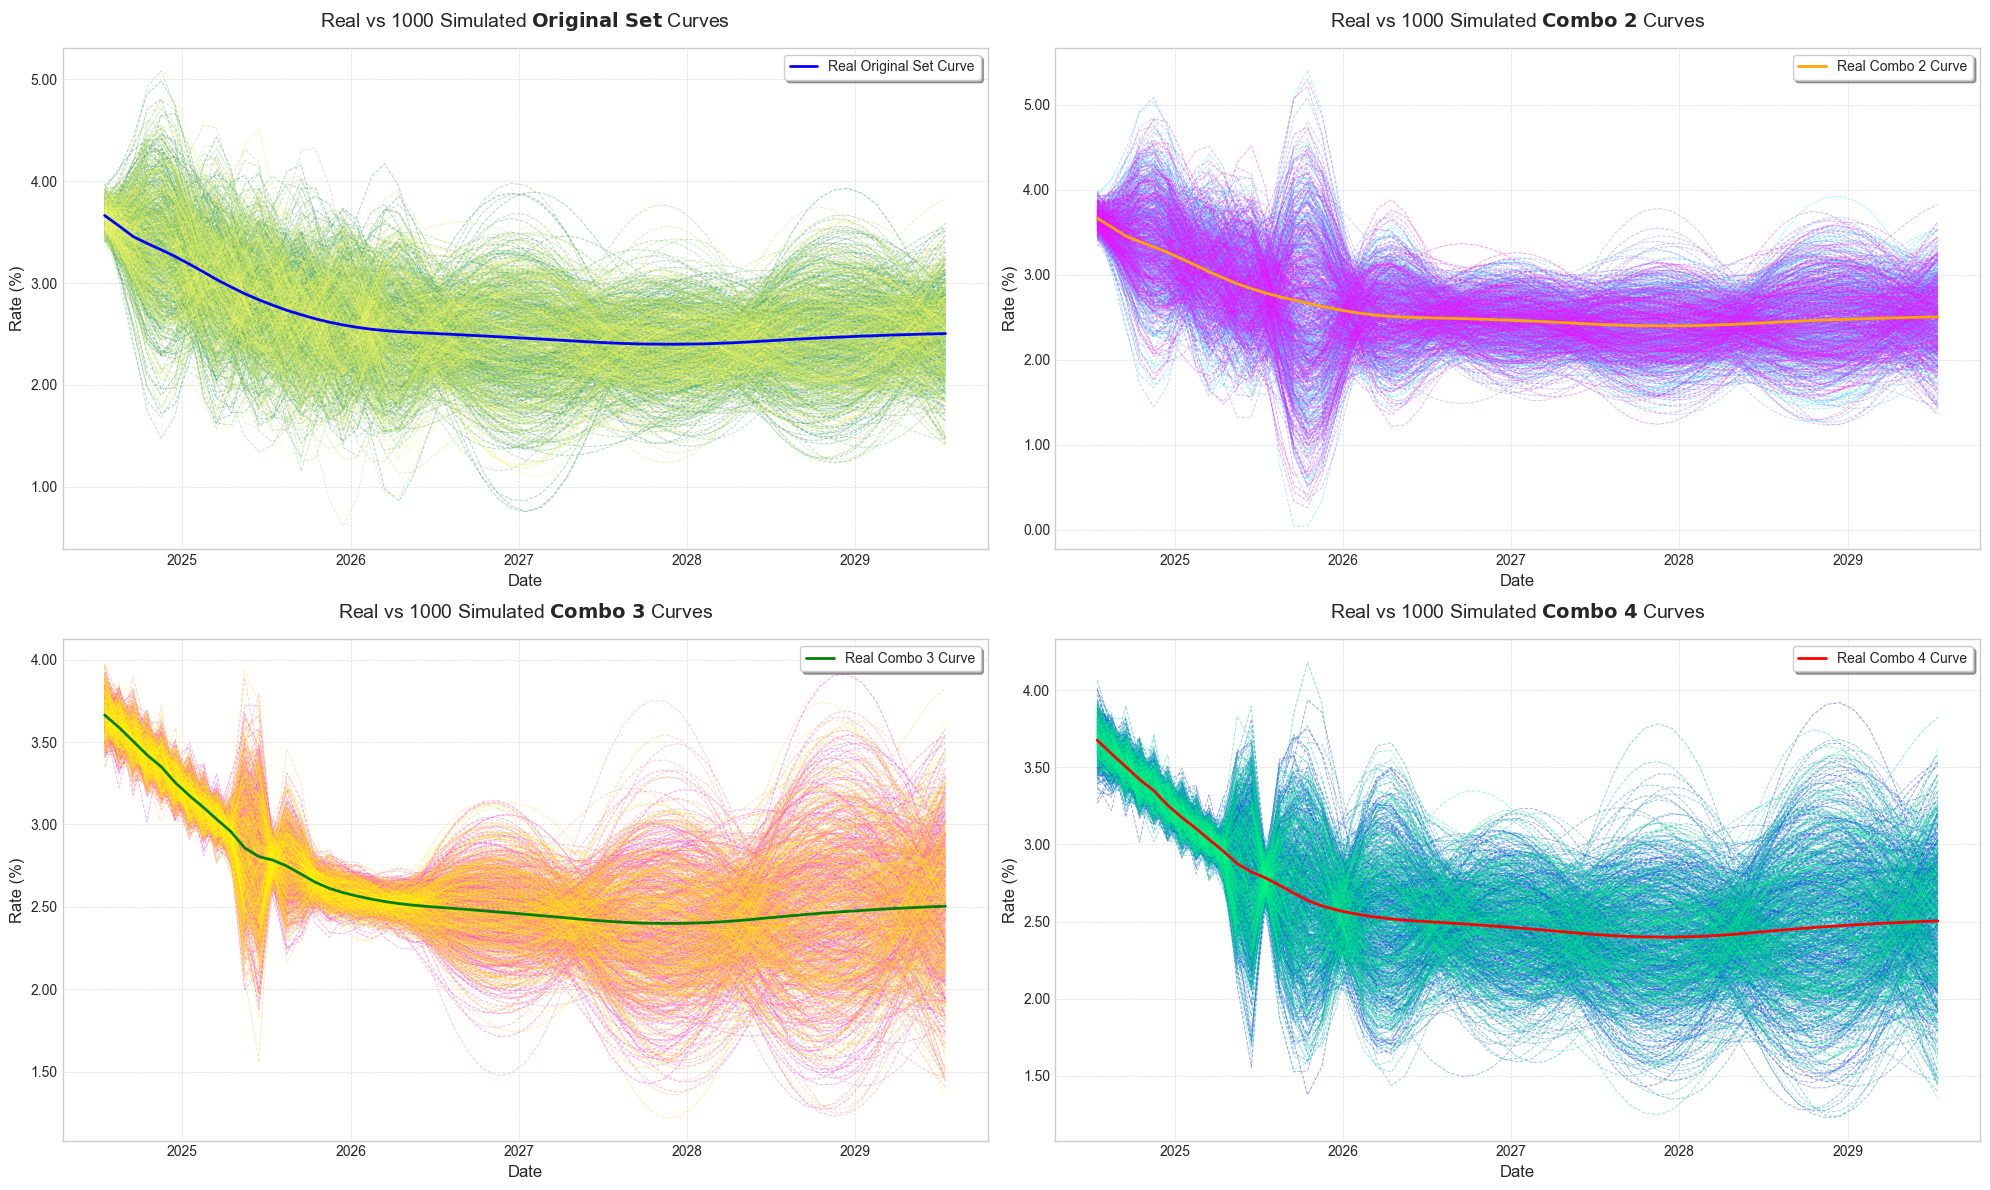

In [12]:
num_simulations = 1000

# Funzione per generare variabili casuali con media zero e deviazione standard pari alla media dello spread
def generate_random_variable(spread, size):
    std_dev = spread.mean()
    return np.random.normal(0, std_dev, size)

# Funzione per applicare lo shock ai dati mantenendo il bid-ask spread positivo
def apply_shock(data, num_simulations):
    data['Spread'] = data['Ask'] - data['Bid']
    simulations = []

    for _ in range(num_simulations):
        random_variable = generate_random_variable(data['Spread'], len(data))
        bid_shocked = data['Bid'] * (1 + random_variable)
        ask_shocked = data['Ask'] * (1 + random_variable)

        # Assicurarsi che il bid-ask spread sia sempre positivo
        ask_shocked = np.where(bid_shocked >= ask_shocked, bid_shocked + abs(data['Spread']), ask_shocked)

        shocked_data = data.copy()
        shocked_data['Bid'] = bid_shocked
        shocked_data['Ask'] = ask_shocked
        shocked_data['Shocked_Spread'] = shocked_data['Ask'] - shocked_data['Bid']
        shocked_data['Mid'] = (shocked_data['Bid'] + shocked_data['Ask']) / 2

        simulations.append(shocked_data.copy()) 

    return simulations

# Applicazione degli shock e ricostruzione delle curve per ogni simulazione
s_ois_data_sim = apply_shock(ois_data, num_simulations)
s_deposit_data_sim = apply_shock(deposit_data, num_simulations)
s_fra_data3M_sim = apply_shock(fra_data3M, num_simulations)
s_forwards_ois_ecb_data_sim = apply_shock(forwards_ois_ecb_data, num_simulations)
s_swap_data3M_sim = apply_shock(swap_data3M, num_simulations)
s_futures_data3M_sim = apply_shock(futures_data3M, num_simulations)


DEBUG_SHIFTDATA = False
if DEBUG_SHIFTDATA:

    for i in range(num_simulations):
        print(s_ois_data_sim[i].head(10))

# Placeholder per curve
euribor3m_f_curve_sim = []
euribor3m_f_curve_combo2_sim = []
euribor3m_f_curve_combo3_sim = []
euribor3m_f_curve_combo4_sim = []

# Placeholder per tracking errors e metriche di errore
tracking_errors_original_set = []
tracking_errors_combo2 = []
tracking_errors_combo3 = []
tracking_errors_combo4 = []

max_variation_original_set = []
min_variation_original_set = []

max_variation_combo2 = []
min_variation_combo2 = []

max_variation_combo3 = []
min_variation_combo3 = []

max_variation_combo4 = []
min_variation_combo4 = []

for i in range(num_simulations):
    try:
        s_estr_curve, s_estr_helpers, s_zero_rates = estr_curve_builder(

            ois_data=s_ois_data_sim[i],
                deposit_data=s_deposit_data_sim[i],
                    forwards_ois_ecb_data=s_forwards_ois_ecb_data_sim[i],
                        graph=False
        )

        s_euribor3m_curve_no_synth_depo, s_euribor3m_f_curve_no_synth_depo, s_fra_0x3_3m_helper, s_future_helpers, s_swap_helpers_dual, spot_date, euribor3m = euribor_curve_builder_no_synth_depo(

            estr_curve=s_estr_curve,
                fra_data3M=s_fra_data3M_sim[i],
                    futures_data3M=s_futures_data3M_sim[i],
                            swap_data3M=s_swap_data3M_sim[i],
                                graph=False
        )

        s_synth_deposit_helper_ON_to_2M = synthetic_deposit_builder(

            euribor3m_curve_no_synth_depo=s_euribor3m_curve_no_synth_depo,
                estr_curve=s_estr_curve,
                    print_alpha=False
        )

        s_euribor3m_curve_with_synth_depo, s_euribor3m_f_curve, _ = euribor_curve_builder_with_synth_depo(

            synth_deposit_helper_ON_to_2M=s_synth_deposit_helper_ON_to_2M,
                fra_0x3_3m_helper=s_fra_0x3_3m_helper,
                    future_helpers=s_future_helpers,
                        swap_helpers_dual=s_swap_helpers_dual,
                            graph=False
        )

        s_euribor3m_f_curve, s_euribor3m_f_curve_combo2, s_euribor3m_f_curve_combo3, s_euribor3m_f_curve_combo4, dates = different_i_b_sets_curves_builder(

            synth_deposit_helper_ON_to_2M=s_synth_deposit_helper_ON_to_2M,
                fra_0x3_3m_helper=s_fra_0x3_3m_helper,
                    swap_helpers_dual=s_swap_helpers_dual,
                        estr_curve=s_estr_curve,
                            euribor3m_curve_with_synth_depo=s_euribor3m_curve_with_synth_depo,
                                futures_data3M=s_futures_data3M_sim[i],
                                    swap_data3M=s_swap_data3M_sim[i],
                                        fra_data3M=s_fra_data3M_sim[i],
                                            graph=False,
                                                graph_comparison=False,
        )

        euribor3m_f_curve_sim.append(s_euribor3m_f_curve)
        euribor3m_f_curve_combo2_sim.append(s_euribor3m_f_curve_combo2)
        euribor3m_f_curve_combo3_sim.append(s_euribor3m_f_curve_combo3)
        euribor3m_f_curve_combo4_sim.append(s_euribor3m_f_curve_combo4)

        #=========================Statistical Analysis============================================

        # Calculate Differences Between Curves
        differences_original_set = np.array(euribor3m_f_curve) - np.array(s_euribor3m_f_curve)
        differences_combo2 = np.array(euribor3m_f_curve_combo2) - np.array(s_euribor3m_f_curve_combo2)
        differences_combo3 = np.array(euribor3m_f_curve_combo3) - np.array(s_euribor3m_f_curve_combo3)
        differences_combo4 = np.array(euribor3m_f_curve_combo4) - np.array(s_euribor3m_f_curve_combo4)

        # Calculate Tracking Error and other metrics (in basis points) for the first 10 years
        tracking_error_original_set = np.sqrt(np.mean(differences_original_set**2)) * 10000
        tracking_error_combo2 = np.sqrt(np.mean(differences_combo2**2)) * 10000
        tracking_error_combo3 = np.sqrt(np.mean(differences_combo3**2)) * 10000
        tracking_error_combo4 = np.sqrt(np.mean(differences_combo4**2)) * 10000

        # Append tracking errors to the lists
        tracking_errors_original_set.append(tracking_error_original_set)
        tracking_errors_combo2.append(tracking_error_combo2)
        tracking_errors_combo3.append(tracking_error_combo3)
        tracking_errors_combo4.append(tracking_error_combo4)

        # Append max and min variations to the lists
        max_variation_original_set.append(np.max(differences_original_set) * 10000)
        min_variation_original_set.append(np.min(differences_original_set) * 10000)
        
        max_variation_combo2.append(np.max(differences_combo2) * 10000)
        min_variation_combo2.append(np.min(differences_combo2) * 10000)
        
        max_variation_combo3.append(np.max(differences_combo3) * 10000)
        min_variation_combo3.append(np.min(differences_combo3) * 10000)
        
        max_variation_combo4.append(np.max(differences_combo4) * 10000)
        min_variation_combo4.append(np.min(differences_combo4) * 10000)
        
    except RuntimeError as e:
        print(f"Simulation {i} failed due to convergence error: {e}")
        continue

#----------------------------------------------------------------------------------------

# Plot the forward curves with the simulated curves
dates_dt = [_to_datetime(date) for date in dates]

fig, axs = plt.subplots(2, 2, figsize=(20, 12))

# Define color maps for each set of simulated curves
colors_simulated_original = plt.cm.summer(np.linspace(0, 1, len(euribor3m_f_curve_sim)))  
colors_simulated_combo2 = plt.cm.cool(np.linspace(0, 1, len(euribor3m_f_curve_combo2_sim)))  
colors_simulated_combo3 = plt.cm.spring(np.linspace(0, 1, len(euribor3m_f_curve_combo3_sim)))  
colors_simulated_combo4 = plt.cm.winter(np.linspace(0, 1, len(euribor3m_f_curve_combo4_sim)))  


# First subplot: Original Set Curve with all simulated curves
for i, curve in enumerate(euribor3m_f_curve_sim):
    axs[0, 0].plot(dates_dt, [rate * 100 for rate in curve], linestyle='--', color=colors_simulated_original[i], linewidth=0.7, alpha=0.4)  # Plot simulated curves first with color
axs[0, 0].plot(dates_dt, [rate * 100 for rate in euribor3m_f_curve], label='Real Original Set Curve', color='blue', linewidth=2)  # Plot the true curve on top
axs[0, 0].xaxis.set_major_locator(mdates.YearLocator(1))
axs[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[0, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
axs[0, 0].set_xlabel('Date', fontsize=12)
axs[0, 0].set_ylabel('Rate (%)', fontsize=12)
axs[0, 0].set_title(r'Real vs 1000 Simulated $\mathbf{Original\ Set}$ Curves', fontsize=14, pad=15)
axs[0, 0].legend(fontsize=10, frameon=True, shadow=True, fancybox=True)
axs[0, 0].grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

# Second subplot: Combo 2 Curve with all simulated curves
for i, curve in enumerate(euribor3m_f_curve_combo2_sim):
    axs[0, 1].plot(dates_dt, [rate * 100 for rate in curve], linestyle='--', color=colors_simulated_combo2[i], linewidth=0.7, alpha=0.4)
axs[0, 1].plot(dates_dt, [rate * 100 for rate in euribor3m_f_curve_combo2], label='Real Combo 2 Curve', color='orange', linewidth=2)  # Plot the true curve on top
axs[0, 1].xaxis.set_major_locator(mdates.YearLocator(1))
axs[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[0, 1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
axs[0, 1].set_xlabel('Date', fontsize=12)
axs[0, 1].set_ylabel('Rate (%)', fontsize=12)
axs[0, 1].set_title(r'Real vs 1000 Simulated $\mathbf{Combo\ 2}$ Curves', fontsize=14, pad=15)
axs[0, 1].legend(fontsize=10, frameon=True, shadow=True, fancybox=True)
axs[0, 1].grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

# Third subplot: Combo 3 Curve with all simulated curves
for i, curve in enumerate(euribor3m_f_curve_combo3_sim):
    axs[1, 0].plot(dates_dt, [rate * 100 for rate in curve], linestyle='--', color=colors_simulated_combo3[i], linewidth=0.7, alpha=0.4)
axs[1, 0].plot(dates_dt, [rate * 100 for rate in euribor3m_f_curve_combo3], label='Real Combo 3 Curve', color='green', linewidth=2)  # Plot the true curve on top
axs[1, 0].xaxis.set_major_locator(mdates.YearLocator(1))
axs[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[1, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
axs[1, 0].set_xlabel('Date', fontsize=12)
axs[1, 0].set_ylabel('Rate (%)', fontsize=12)
axs[1, 0].set_title(r'Real vs 1000 Simulated $\mathbf{Combo\ 3}$ Curves', fontsize=14, pad=15)
axs[1, 0].legend(fontsize=10, frameon=True, shadow=True, fancybox=True)
axs[1, 0].grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

# Fourth subplot: Combo 4 Curve with all simulated curves
for i, curve in enumerate(euribor3m_f_curve_combo4_sim):
    axs[1, 1].plot(dates_dt, [rate * 100 for rate in curve], linestyle='--', color=colors_simulated_combo4[i], linewidth=0.7, alpha=0.4)
axs[1, 1].plot(dates_dt, [rate * 100 for rate in euribor3m_f_curve_combo4], label='Real Combo 4 Curve', color='red', linewidth=2)  # Plot the true curve on top
axs[1, 1].xaxis.set_major_locator(mdates.YearLocator(1))
axs[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[1, 1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
axs[1, 1].set_xlabel('Date', fontsize=12)
axs[1, 1].set_ylabel('Rate (%)', fontsize=12)
axs[1, 1].set_title(r'Real vs 1000 Simulated $\mathbf{Combo\ 4}$ Curves', fontsize=14, pad=15)
axs[1, 1].legend(fontsize=10, frameon=True, shadow=True, fancybox=True)
axs[1, 1].grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()




Figures - Comparison of Euribor 3M forward curves for different bootstrapping instrument sets. The figure displays the forward curves constructed using four distinct combinations of market instruments: the original set (blue line) includes synthetic deposits, the 0X3M FRA, futures, and swaps; Combo 2 (orange line) places more emphasis on swaps; Combo 3 (green line), replaces futures with additional FRAs to capture medium-term rates; and Combo 4 (red line) also uses a mix of FRAs but with an increased focus on swaps.

In [13]:

#=========================Statistical Analysis============================================
# Calculate the mean tracking error and the mean max/min variation for each set of curves
mean_tracking_error_original_set = np.mean(tracking_errors_original_set)
mean_max_variation_original_set = np.mean(max_variation_original_set)
mean_min_variation_original_set = np.mean(min_variation_original_set)

mean_tracking_error_combo2 = np.mean(tracking_errors_combo2)
mean_max_variation_combo2 = np.mean(max_variation_combo2)
mean_min_variation_combo2 = np.mean(min_variation_combo2)


mean_tracking_error_combo3 = np.mean(tracking_errors_combo3)
mean_max_variation_combo3 = np.mean(max_variation_combo3)
mean_min_variation_combo3 = np.mean(min_variation_combo3)

mean_tracking_error_combo4 = np.mean(tracking_errors_combo4)
mean_max_variation_combo4 = np.mean(max_variation_combo4)
mean_min_variation_combo4 = np.mean(min_variation_combo4)

# Create a list of tuples for easy sorting
results = [
    ("Original Set", mean_tracking_error_original_set, mean_max_variation_original_set, mean_min_variation_original_set, tracking_errors_original_set),
    ("Combo 2", mean_tracking_error_combo2, mean_max_variation_combo2, mean_min_variation_combo2, tracking_errors_combo2),
    ("Combo 3", mean_tracking_error_combo3, mean_max_variation_combo3, mean_min_variation_combo3, tracking_errors_combo3),
    ("Combo 4", mean_tracking_error_combo4, mean_max_variation_combo4, mean_min_variation_combo4, tracking_errors_combo4),
]

# Sort the list by the mean tracking error
results.sort(key=lambda x: x[1])

# Print the combined analysis
for name, mean_te, mean_max_var, mean_min_var, errors in results:
    # Perform one-sample t-test
    t_stat, p_value = ttest_1samp(errors, 0)
    significance = "statistically significant" if p_value < 0.05 else "not statistically significant"
    
    # Print the combined analysis for each combo
    print(f"Analysis for {name}:")
    print(f"  Mean Tracking Error: {mean_te:.2f} bps")
    print(f"  Mean Max Variation: {mean_max_var:.2f} bps")
    print(f"  Mean Min Variation: {mean_min_var:.2f} bps")
    print(f"  t-statistic: {t_stat:.2f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Result: The mean is {significance} (at 95% confidence level).")
    print("--------------------------------------------------------------------------------")    

Analysis for Combo 3:
  Mean Tracking Error: 24.10 bps
  Mean Max Variation: 48.80 bps
  Mean Min Variation: -48.65 bps
  t-statistic: 73.58
  p-value: 0.0000
  Result: The mean is statistically significant (at 95% confidence level).
--------------------------------------------------------------------------------
Analysis for Combo 4:
  Mean Tracking Error: 28.78 bps
  Mean Max Variation: 57.83 bps
  Mean Min Variation: -57.88 bps
  t-statistic: 87.14
  p-value: 0.0000
  Result: The mean is statistically significant (at 95% confidence level).
--------------------------------------------------------------------------------
Analysis for Combo 2:
  Mean Tracking Error: 38.13 bps
  Mean Max Variation: 83.50 bps
  Mean Min Variation: -81.32 bps
  t-statistic: 89.63
  p-value: 0.0000
  Result: The mean is statistically significant (at 95% confidence level).
--------------------------------------------------------------------------------
Analysis for Original Set:
  Mean Tracking Error: 38.67